# Taiwan Stock High-Frequency Trading Portfolio Strategy: Machine Learning-Based Minute-Level Prediction and Backtesting System
## 台股高頻交易投資組合策略：基於機器學習的分鐘級預測與回測系統

## Overview

 This project focuses on minute-level trading data of 25 major weighted stocks in the Taiwan stock market. It performs feature engineering by combining multi-factor signals and technical indicators, and uses a LightGBM model to predict short-term returns. The predicted results are validated through dual-mode backtesting (`from_signals` and `from_order_func`) using the `vectorbt` framework, effectively evaluating the performance of both signal-based and position-controlled strategies.

 本專案專注於台股25檔權值股的分鐘級資料，結合多因子特徵與技術指標進行特徵工程，透過LightGBM模型預測短期報酬，預測結果將透過`vectorbt`框架進行雙模式回測分析（`from_signals`與`from_order_func`），以驗證模型預測訊號及倉位控制策略的實際效能。

## Workflow

- **Data Collection & Preprocessing**: 

    - Collect minute-level OHLCV data from Taiwan's top 25 market cap stocks, performing data cleaning and preprocessing.


- **Feature Engineering**: 
    
    - Extract 101 alphas and common price-volume factors for high-frequency trading.
    - Refine and engineer raw features, including transformations and return calculations.

- **Data Splitting**:
    - Split data by rolling time windows into 9 training-validation sets and 1 testing set.

- **Model Training**:
    - Use a custom Information Coefficient (IC) as the evaluation metric for model performance.
    - Train and optimize the model using `LightGBM` in combination with `Optuna` library.

- **Model Testing**:
    - Apply the best parameters from the final model to predict on the test set.
    - Visualize the prediction results on the test set to observe performance.

- **Backtesting**: 
    - Built trading strategies using both the `from_signals` and `from_order_func` methods from the `vectorbt.Portfolio` module.
    - Select and prioritize strategy indicators, and implement customized trading logic including entry/exit order, position sizing, capital constraints, and more.

## Import Package, Settings
 Import necessary Python packages including data processing, machine learning, and backtesting tools, with initialization configurations.

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import os
import plotly
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image, display, SVG
import os
    
import shap

import vectorbt as vbt
import datetime as dt
import talib as ta

import string as str
import random

import lightgbm as lgb
import optuna
from functools import partial
from tqdm.auto import tqdm
import time
import joblib
import warnings
warnings.filterwarnings('ignore')  # 關掉所有警告

# print(os.getcwd())
# print(os.path.abspath("example.txt"))

import sys
sys.path.append('c:\\python_vs\\WorldQuant_alpha101_code')
from Alpha_code_1 import *

## 處理中文亂碼
def plt_chinese():
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
    plt.rcParams['axes.unicode_minus'] = False # 顯示負號

plt_chinese()

# Fubon API
# from fubon_neo.sdk import FubonSDK, Order   
# sdk = FubonSDK()
# accounts = sdk.login("id", "password", "C:/CAFubon/id/id.pfx", "password")  # 需登入後，才能取得行情權限
# sdk.init_realtime() # 建立行情連線
# reststock = sdk.marketdata.rest_client.stock  

GITHUB_VER = True  # 上傳github時切換成True，還要將有plotly圖的地方重跑!!!
pio.renderers.default='notebook_connected'

# 針對顯示plotly圖像的額外設計（在github顯示靜態圖，網頁顯示動態圖）
# 流程：實作時顯示動態圖+儲存html檔，上傳時顯示靜態圖+另外上傳已儲存的html檔（更：暫不儲存任何圖檔）
def show_plotly(fig, export_for_github=GITHUB_VER, format='svg'):
    """
    顯示 Plotly 圖。如果 export_for_github=True，會從檔案載入靜態圖顯示。
    否則顯示互動圖，並儲存靜態版本供 GitHub 預覽使用。
    
    Parameters:
    - fig: Plotly figure
    - export_for_github: 是否啟用 GitHub 模式（只載入圖檔），上傳github時切換GITHUB_VER
    - format: 'png' or 'svg'
    """
    assert format in ['png', 'svg'], "format 必須為 'png' 或 'svg'"
    
    # 確保資料夾存在
    # os.makedirs(folder, exist_ok=True)
    # 儲存html檔案路徑
    # fig_name: 儲存圖檔的名稱（不含副檔名）; folder='Strategy_hft_1_plotly_img'
    # file_path = os.path.join(folder, f"{fig_name}.html")
    
    if export_for_github:
        # 讀取靜態圖檔並顯示

        if format == 'png':
            # display(Image(filename=file_path))
            display(Image(pio.to_image(fig, format=format)))
        elif format == 'svg':
            # display(SVG(filename=file_path))
            display(SVG(pio.to_image(fig, format=format)))
    else:
        # # 儲存靜態圖檔（避免之後重跑）
        # if not os.path.exists(file_path):
        #     # img_bytes = pio.to_image(fig, format=format)

        #     with open(file_path, 'wb') as f:
        #         fig.write_html(file_path)
        # 顯示互動圖
        fig.show()


## Data Collection & Preprocessing

- Choose Taiwan's top 25 market cap stocks as target stocks. (Based on the ranking as of April 30, 2025)

- Collect minute-level OHLCV data for each stock from April 23 to June 2, 2025, covering approximately six weeks of trading days.

- Reference of the market cap stocks ranking：https://www.taifex.com.tw/cht/9/futuresQADetail

In [2]:
# s = dict()

tickers = ['2330','2454','2317','2881','2412','2382','2308','2882','2891','3711',
              '2303','2886','2884','2603','1216','2357','3045','2885','2880','5880',
              '2892','6669','2207','2345','6505']

# for i in tickers:
#     ss = reststock.historical.candles(**{"symbol": i, "from": "2025-05-24", "to": "2025-05-30", "timeframe":"1", "sort":"asc"})['data']  # Fubon API
#     s[i] = pd.DataFrame(ss)
#     s[i]['date'] = pd.to_datetime(s[i]['date']).dt.tz_localize(None)
#     s[i].set_index(['date'],inplace=True)
#     s[i]['vwap'] = vbt.pandas_ta('VWAP').run(s[i][['high']], s[i][['low']], s[i][['close']], s[i][['volume']]).vwap_d.iloc[:,0]

# # 存儲為 HDF5 文件，每個key對應到該股票資料（方便個別股票修改、開啟）
# with pd.HDFStore('c:\\python_vs\\strategy\\stock_hft_0423_0602.h5', mode="a") as store:  #mode="a"為追加（有則覆蓋，無則新增）
#     for stock, df in s.items():
#         store.put(key=stock, value=df)  # 用股票名稱作為 key

stocks0 = {}
with pd.HDFStore("c:\\python_vs\\strategy\\stock_hft_0423_0602.h5", mode="r") as store:
    keys = [key.lstrip('/') for key in store.keys()]
    print(keys)
    for key in keys:
        stocks0[key] = store[key]

#  更改資料儲存格式      # {'open': DataFrame(各股票open), 'high': DataFrame(各股票high),...}
stocks = {col: pd.concat({stock: df[col] for stock, df in stocks0.items()},axis=1) for col in stocks0['2330'].columns}

# 補遺失值（避免技術指標無法計算）（volume用0補，其他前向填補）
for col in stocks.keys():
    if col=='volume':
        stocks[col].fillna(0, inplace=True)
    else:
        stocks[col].ffill(inplace=True)


['1216', '2207', '2303', '2308', '2317', '2330', '2345', '2357', '2382', '2412', '2454', '2603', '2880', '2881', '2882', '2884', '2885', '2886', '2891', '2892', '3045', '3711', '5880', '6505', '6669']


## Feature Engineering

### Get 101 alphas
- The alpha number only collected: 2, 3, 5, 6, 7, 11, 12, 13, 15, 16, 18, 20, 27, 30, 33, 40, 41, 42, 44, 50, 51, 53, 54, 60, 83, 101

- The above selected alphas **DO NOT involve** a time lag (d) greater than 10 or non-integer values (unsuitable for minute-level data), **DO NOT require** stock classification, and **DO NOT rely on** market capitalization or returns in their computation.

In [3]:
# create features (101 alphas)（每日分開處理，避免開收盤波動跨日影響）

# "排除"時間差(d)>10或是非整數（不適用於分鐘級資料）、需進行股票分類、計算上須用到市值(market cap)、報酬率(return)的alpha

from Alpha_code_1 import *

stocks_copy = stocks.copy()  # 因get_alpha()會直接改變stocks1內容，因此複製一個備用

def get_alphas_daily_stack_df(df_dict):  # input: {indicator: df of indicator (row, col = date, ticker)}
    
    dates = df_dict['open'].index.normalize().unique()  # 每個indicator df的row, col皆相同的情況下才能直接指定其中一個的row
    df_dict_date = {}
    df_stacked_date = []
    for date in dates:
        df_dict_date[date] = {indicator: val.loc[val.index.normalize() == date] for indicator, val in df_dict.items()}  # 把不同日期的資料拆開
        get_alpha(df_dict_date[date])   # 不同日期分開算101 alphas（不跨日計算）

# 再更改資料格式為一個DataFrame，index為時間、股票代號，columns為各股票的open、high、low、close等

        df_stacked_date.append(
            pd.concat({indicator:    # 把各個indicator的df stacked成一個col，並且concat（row, col = date*ticker, indicator)
                      df_dict_date[date][indicator].stack() 
                      for indicator in df_dict_date[date].keys()}, axis=1, join='outer'))
        
    # 輸出各日合併之df之df
    return pd.concat(df_stacked_date, axis=0).sort_index()


# kk = {date: 
#       get_alpha({key: val.loc[val.index.normalize() == date] for key, val in stocks.items()}) 
#       for date in dates}

# stocks1 = pd.concat({date: 
#            pd.concat({indicator: 
#                       kk[date][indicator].stack() 
#                       for indicator in kk[date].keys()}, axis=1, join='outer')\
#                         .sort_index() 
#                       for date in dates}, axis=0)

In [4]:
stocks1 = get_alphas_daily_stack_df(stocks)

stocks1.index.rename(names = ['date', 'ticker'], inplace = True)

stocks1.head()

open   high    low  close  volume        vwap  \
date                ticker                                                    
2025-04-23 09:00:00 1216     75.40   75.7   75.1   75.1   341.0   75.300000   
                    2207    594.00  600.0  594.0  600.0    11.0  598.000000   
                    2303     44.95   45.3   44.9   45.2  3463.0   45.133333   
                    2308    316.50  320.5  315.5  316.5   703.0  317.500000   
                    2317    136.00  137.0  136.0  137.0  4835.0  136.666667   

                            alpha002  alpha003  alpha005  alpha006  ...  \
date                ticker                                          ...   
2025-04-23 09:00:00 1216         0.0       0.0 -0.003759       0.0  ...   
                    2207         0.0       0.0 -0.210526       0.0  ...   
                    2303         0.0       0.0 -0.996241       0.0  ...   
                    2308         0.0       0.0 -0.003759       0.0  ...   
                    2317         0.0       0.0 -0.338346       0.0  ...   

                            alpha041    alpha042  alpha044  alpha050  \
date                ticker                                             
2025-04-23 09:00:00 1216    0.099403  266.000000      -0.0       NaN   
                    2207   -1.007538  211.000000      -0.0       NaN   
                    2303   -0.033777    0.007519      -0.0       NaN   
                    2308    0.490173  133.000000      -0.0       NaN   
                    2317   -0.167582    6.807692      -0.0       NaN   

                            alpha051  alpha053  alpha054  alpha060  alpha083  \
date                ticker                                                     
2025-04-23 09:00:00 1216         NaN       NaN  0.000000       NaN       NaN   
                    2207         NaN       NaN -0.950990       NaN       NaN   
                    2303         NaN       NaN -0.729487       NaN       NaN   
                    2308         NaN       NaN -0.200000       NaN       NaN   
                    2317         NaN       NaN -0.964033       NaN       NaN   

                            alpha101  
date                ticker            
2025-04-23 09:00:00 1216   -0.499168  
                    2207    0.999833  
                    2303    0.623441  
                    2308    0.000000  
                    2317    0.999001  

[5 rows x 33 columns]

### Encoding Adjusting

- Adjust categorical and time variables to machine-readable formats.

- Add labels for times near market open and close.

In [5]:
# 取出交易日期、時間資料
stocks1['day'] = pd.to_datetime(stocks1.index.get_level_values('date')).date
stocks1['time'] = pd.to_datetime(stocks1.index.get_level_values('date')).time

# 股票名稱、日期的Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stocks1['stock_encoded'] = le.fit_transform(stocks1.index.get_level_values('ticker'))
stocks1['day_encoded'] = le.fit_transform(stocks1['day'])
stocks1['time_encoded'] = le.fit_transform(stocks1['time'])

# 開收盤會有較大的波動，將開收盤10, 20分鐘內的資料做標記
stocks1['close_10min'] = stocks1['time'].between(dt.time(13,21,0),dt.time(13,30,0))
stocks1['close_20min'] = stocks1['time'].between(dt.time(13,11,0),dt.time(13,30,0))
stocks1['open_10min'] = stocks1['time'].between(dt.time(9,0,0),dt.time(9,9,59))
stocks1['open_20min'] = stocks1['time'].between(dt.time(9,0,0),dt.time(9,19,59))

# import category_encoders as ce

# stocks1['stock_id'] = stocks1.index.get_level_values('ticker')

# # Target Encoding
# target_encoder = ce.TargetEncoder(cols=['stock_id'])
# stocks1['stock_encoded'] = target_encoder.fit_transform(stocks1['stock_id'], stocks1['fwd_ret_1'])

# # 建立映射（類別 → 均值）
# stock_mapping = stocks1.groupby('ticker')['stock_encoded'].mean().to_dict()

# # test_data['stock_encoded'] = test_data['stock'].map(stock_mapping)

### Returns Calculating

 Compute past and forward returns to serve as modeling targets.

In [6]:
# 計算過去1~10分鐘的報酬率
for i in range(1,11):
    stocks1[f'past_ret_{i}'] = stocks1.groupby(['ticker','day'])['close'].transform(lambda x: x.pct_change(periods=i)).fillna(0)
    # stocks1.groupby(['ticker','day']).apply(lambda x: x['close']/(x['open'].shift(1))-1, include_groups=False).reset_index(level=[0,1],drop=True).reindex(stocks1.index)
    # 過去i分鐘return（now close - i min ago)/ago
    # pct_change(periods=i)計算i分鐘前到now的報酬率
    # NaN代表該時間無資料，補0以避免模型預測報錯

# 計算未來1, 3, 5, 10分鐘後的報酬率（與當前比較）
for i in [1, 3, 5, 10]:
    stocks1[f'fwd_ret_{i}'] = stocks1.groupby(['ticker','day'])['close'].transform(lambda x: x.pct_change(periods=i).shift(-i)).fillna(0)
    # i分鐘後return（i min later close - now)/now
    # pct_change(periods=i)計算i分鐘前到now的報酬率，shift(-i)將其移動到當前時間點
    # NaN代表該時間無資料，補0以避免模型預測報錯

# stocks1.groupby('ticker').resample('1T', level='date').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last'})

### Technical Indicators by `TaLib`

Generate common technical indicators (suitable for HFT data) using `TaLib`.

In [7]:
# 技術指標（以下指標均跨日計算，避免開盤受前一日影響）

# stocks1.groupby('ticker').apply(lambda x: ta.BOP(x['open'], x['high'], x['low'], x['close']))

### BOP (Balance of Power，力量平衡)
# 範圍-1~+1，正值看漲、負值看跌
stocks1['BOP'] = stocks1.groupby('ticker').apply(lambda x: ta.BOP(x['open'], x['high'], x['low'], x['close'])).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### CCI (Commodity Channel Index, 順勢指標)
# 現值與MA的偏離，通常範圍-100~+100，往上漲破100買進，往下跌破-100賣出
stocks1['CCI'] = stocks1.groupby('ticker').apply(lambda x: ta.CCI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### MFI（Money Flow Index, 資金流量指標）
# 又稱Volume Relative Strength Index，成交量加權RSI，範圍0~100，>80超買-->賣出，<20超賣-->買入
# 走勢跟價格走勢相反-->背離，低點MFI新高點-->低價買入，高點MFI新低點-->高價賣出
stocks1['MFI'] = stocks1.groupby('ticker').apply(lambda x: ta.MFI(x['high'], x['low'], x['close'], x['volume'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### STOCHRSI (Stochastic RSI, 應用KD隨機指標的RSI)
# 比RSI更敏感、波動更快，範圍0~100，k>d-->看漲買入，且<20超賣-->必買入，k<d-->看跌賣出，且>80超買-->必賣出
stocks1['STOCHRSI'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCHRSI(x['close'], timeperiod=10, 
                                                         fastk_period=5, fastd_period=3, # k,d period用預設值
                                                         fastd_matype=0)[0]).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### STOCH (Stochastic Oscillator，KD隨機指標)
# ％K、％D、Slow％D三條線
# %K: (now close - past N low) / (past N high - past N low)
# %D: M period sum of (now close - past N low) / M period sum of (past N high - past N low)
# Slow%D: T period average of %D

stocks1['slowK'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCH(x['high'], x['low'], x['close'], 
                                                            fastk_period=10,  # %K
                                                            slowk_period=3,  # %D
                                                            slowk_matype=0,
                                                            slowd_period=3,  # Slow%D
                                                            slowd_matype=0)[0]).\
                                                            reset_index(level=0,drop=True).reindex(stocks1.index)

stocks1['slowD'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCH(x['high'], x['low'], x['close'], 
                                                            fastk_period=10,  # %K
                                                            slowk_period=3,  # %D
                                                            slowk_matype=0,
                                                            slowd_period=3,  # Slow%D
                                                            slowd_matype=0)[1]).\
                                                            reset_index(level=0,drop=True).reindex(stocks1.index)

### NATR (Normalized Average True Range，正則化平均真實波動)
# TR = max[(high - low), abs(high - previous close), abs (low - previous close)]
# ATR = [ previous ATR * (N-1) + TR ]/N
# 值愈大波動愈大

stocks1['NATR'] = stocks1.groupby('ticker').apply(lambda x: ta.NATR(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### ADX (Average Directional Index, 平均動向指標)
# 範圍0~100，值愈大（通常>30）趨勢愈明顯（無論漲跌）
stocks1['ADX'] = stocks1.groupby('ticker').apply(lambda x: ta.ADX(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### DI_diff 
# DI+ > DI- -->看漲，DI+ < DI- -->看跌，趨勢不明顯時可能背離
DI_plus = stocks1.groupby('ticker').apply(lambda x: ta.PLUS_DI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

DI_minus = stocks1.groupby('ticker').apply(lambda x: ta.MINUS_DI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

stocks1['DI_diff'] = DI_plus-DI_minus


### OBV (On Balance Volume, 平衡交易量)
# 將起伏大的交易量轉為可視覺化的連續指標
# 上漲日成交量累加，下跌日則減去

stocks1['OBV'] = stocks1.groupby('ticker').apply(lambda x: ta.OBV(x['close'], x['volume'])).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### Features Description and Visualization

Provide descriptive statistics and visualizations of the features.

In [8]:
ret_col = stocks1.filter(regex='fwd_ret').columns   # 篩選出名稱含fwd_ret的column（這些是要被預測的目標變數）
delete_col = stocks1.filter(items=["day", "time", "open", "high", "low", "close"]).columns  # 這些column將不放入模型

stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 179550 entries, (Timestamp('2025-04-23 09:00:00'), '1216') to (Timestamp('2025-06-02 13:30:00'), '6669')
Data columns (total 56 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   volume         179550 non-null  float64
 1   vwap           179550 non-null  float64
 2   alpha002       179550 non-null  float64
 3   alpha003       179550 non-null  float64
 4   alpha005       179550 non-null  float64
 5   alpha006       179550 non-null  float64
 6   alpha007       170001 non-null  float64
 7   alpha011       177525 non-null  float64
 8   alpha012       178875 non-null  float64
 9   alpha013       176850 non-null  float64
 10  alpha015       179550 non-null  float64
 11  alpha016       176850 non-null  float64
 12  alpha018       176850 non-null  float64
 13  alpha020       178875 non-null  float64
 14  alpha027       179550 non-null  float64
 15  alpha030       177374 non-null  float64
 1

#### Five-Number Summary

In [9]:
# Five-number summary for explanatory features 
stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
volume,179550.0,88.129563,664.804317,0.000000e+00,6.000000,21.000000,65.000000,1.399920e+05
vwap,179550.0,330.719118,503.138631,2.375333e+01,38.854815,114.341832,373.034306,2.451454e+03
alpha002,179550.0,-0.004801,0.419491,-1.000000e+00,-0.298267,0.000000,0.284423,9.970817e-01
alpha003,179550.0,0.010012,0.341002,-1.000000e+00,-0.224809,0.000000,0.246972,1.000000e+00
alpha005,179550.0,-0.314560,0.280644,-1.000000e+00,-0.520776,-0.235132,-0.064362,-1.413308e-05
alpha006,179550.0,0.009418,0.341792,-1.000000e+00,-0.219081,0.000000,0.240652,1.000000e+00
alpha007,170001.0,-0.850077,16.595715,-6.000000e+01,-1.000000,-1.000000,-1.000000,6.000000e+01
alpha011,177525.0,0.504860,0.428647,4.320774e-05,0.155296,0.391433,0.754666,2.000000e+00
alpha012,178875.0,0.004016,1.040520,-3.000000e+01,0.000000,0.000000,0.000000,3.000000e+01
alpha013,176850.0,-0.501908,0.288003,-1.000000e+00,-0.751908,-0.505725,-0.251908,-3.816794e-03


In [10]:
# Five-number summary for target features
stocks1[ret_col].describe().T

,count,mean,std,min,25%,50%,75%,max
fwd_ret_1,179550.0,0.000003,0.001592,-0.029221,0.000000,0.0,0.000000,0.032609
fwd_ret_3,179550.0,0.000005,0.002010,-0.029221,-0.001046,0.0,0.001024,0.036957
fwd_ret_5,179550.0,0.000008,0.002308,-0.026059,-0.001248,0.0,0.001238,0.036957
fwd_ret_10,179550.0,0.000011,0.002865,-0.029276,-0.001422,0.0,0.001389,0.032609


#### Histogram and Kernel Density of Features 

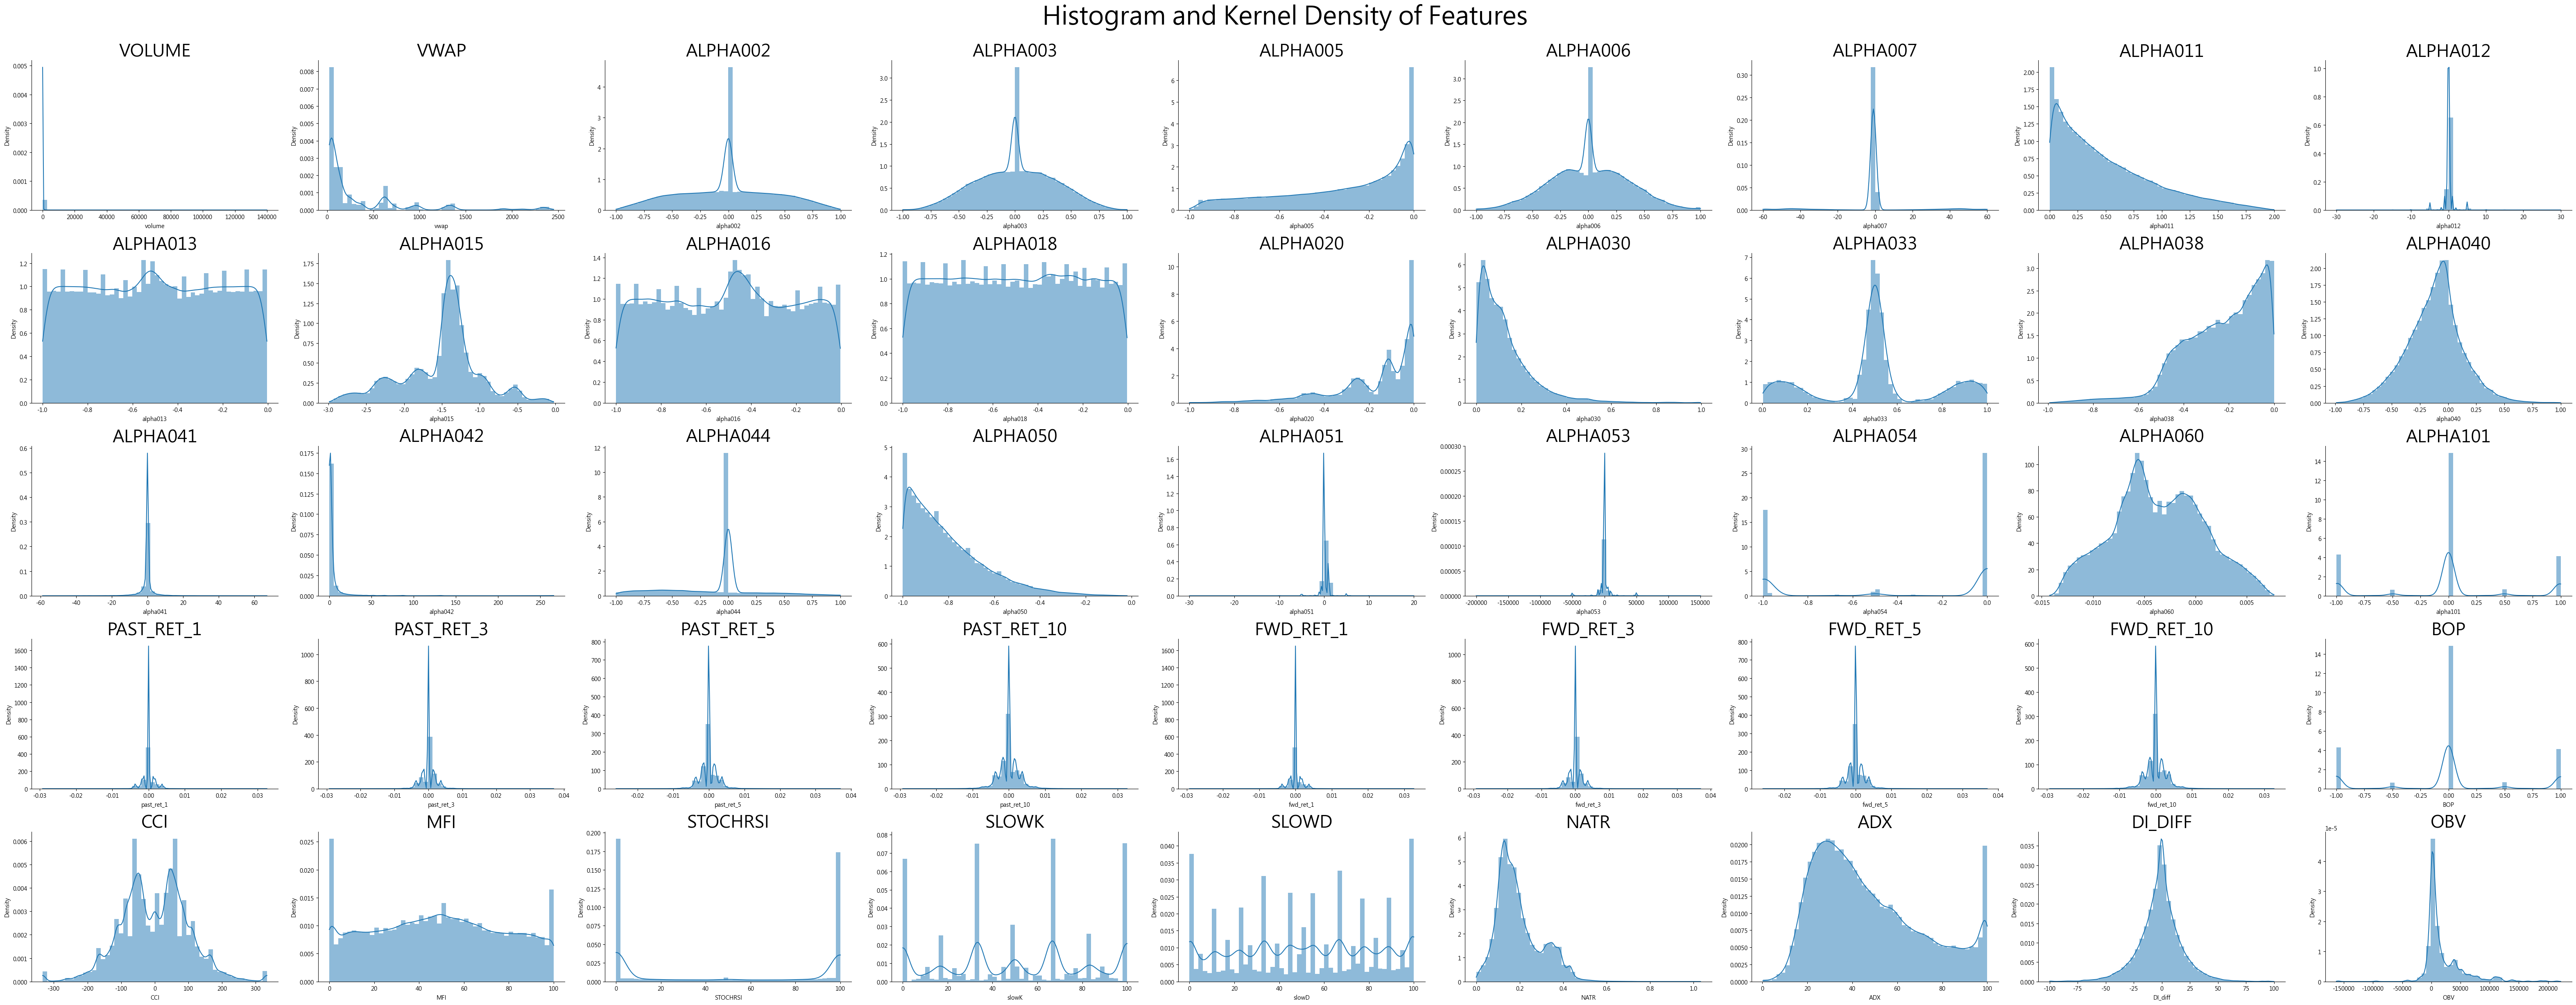

In [11]:
# 排除異常（標準差為0或NaN的column）
abnormal_col = stocks1.filter(items = ["alpha027", "alpha40", "alpha083"]).columns 

# 排除encoded column且只保留過去1,3,5,10分鐘報酬率column
abandon_col = stocks1.filter(items = ['stock_encoded', 'day_encoded','time_encoded', 'close_10min', 'close_20min', 
                                      'open_10min','open_20min', 'past_ret_2', 'past_ret_4', 'past_ret_6', 'past_ret_7', 
                                      'past_ret_8', 'past_ret_9']).columns 

###### 以上排除的column只是不參與視覺化，仍會加入模型訓練 ######

features = stocks1.drop(delete_col, axis=1).drop(abnormal_col, axis=1).drop(abandon_col, axis=1).columns

# 設定圖形大小與子圖
ncols = 9
nrows = (len(features) + ncols - 1) // ncols  # 自動根據特徵數量決定行數
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 5))
axes = axes.flatten()

# 繪圖
for i, feature in enumerate(features):
    ax=axes[i]
    sns.histplot(stocks1[feature], kde=True, ax=ax, bins=50, stat="density", linewidth=0)
    ax.set_title(feature.upper(), fontsize=30)
    
# 多餘子圖清空
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

sns.despine()
fig.suptitle("Histogram and Kernel Density of Features ", fontsize=44)
plt.tight_layout(rect = [0,0,1,0.98])
plt.show()

#### Heatmap of Features

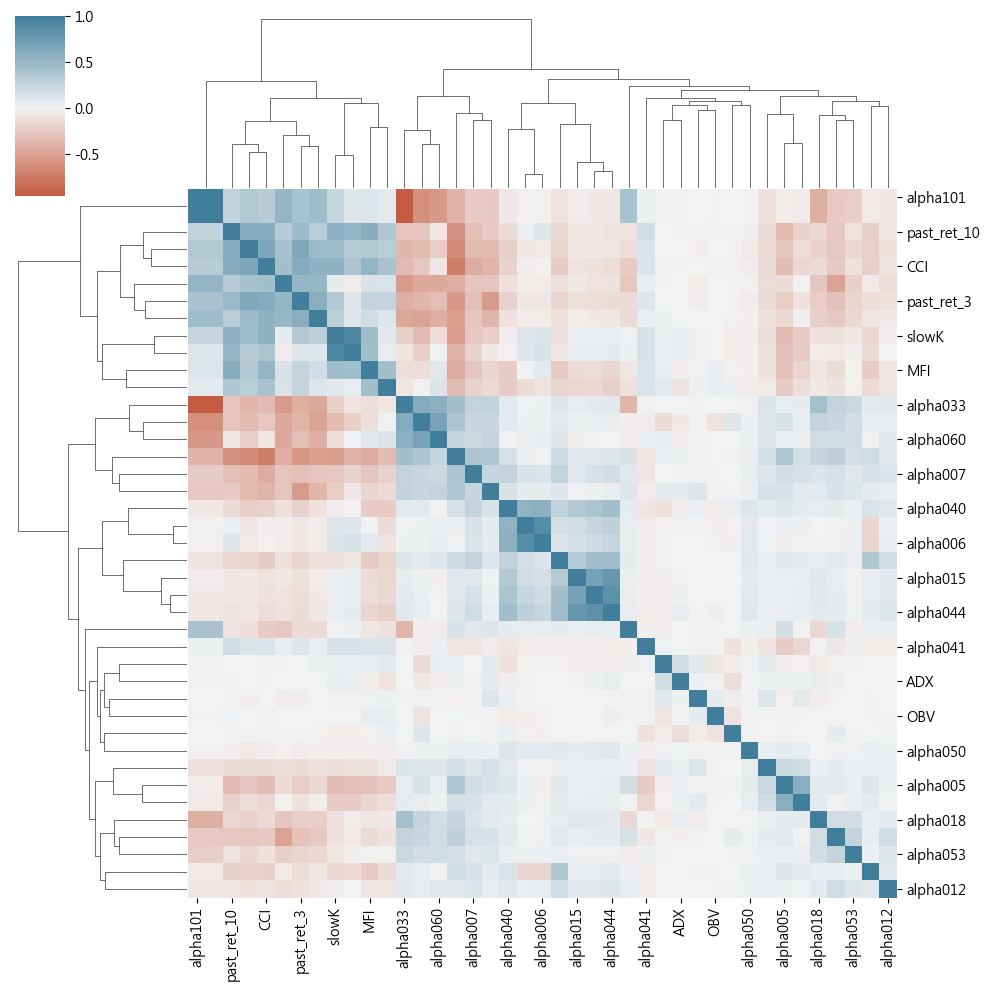

In [12]:
corr = stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).drop(abnormal_col, axis=1).drop(abandon_col, axis=1).corr()

sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0)
plt.show()

## Data Splitting

- Split the time-series data into training, validation, and testing sets.

- Employ rolling time windows to split data into 9 training-validation sets.

- Each training-validation set consists of 4 days of training data and 2 days of validation data.

- The last 5 trading days of data are retained as testing sets.

In [13]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

class RollingTimeSeriesCV:
    """
    Generates tuples of train_idx, valid_idx pairs
    按日期分組，預設每次訓練4天，驗證2天，每次驗證間隔2天
    提供兩種版本：預設n_split（暫不設計）、預設訓練/驗證時間長度
    """
# 共25檔股票，每日分K資料共266筆
    def __init__(self, 
                 DATA=None,
                #  n_splits=5,
                 period_length=266,  # 每個基本時間段長度（例如：每天有266分鐘的資料）
                 train_day_length=4,  # 每次train 4天資料
                 valid_day_length=2,  # 每次valid 2天資料
                 step_day_length=2,  # 驗證集間隔2天
                 test_day_length=5,  #test資料共5天
                #  lookahead=None,  # 往前面的時間回推
                 date_idx='date'):
        self.DATA = DATA
        # self.n_splits = n_splits
        # self.lookahead = lookahead
        # self.period_length = period_length
        self.valid_length = int(valid_day_length * period_length)
        self.train_length = int(train_day_length * period_length)
        self.step_length = int(step_day_length * period_length)
        self.test_day_length = int(test_day_length * period_length)   

        self.date_idx = date_idx
        self.train_valid_time_idxs = []
        
        DATA_time_each = (self.DATA).index.get_level_values(self.date_idx)  #每筆資料的時間
        self.DATA_time = DATA_time_each.unique()   # 資料的時間序
        DATA_time_idx = [i for i,j in enumerate(self.DATA_time)]   # 時間序的idx
        self.test_times = self.DATA_time[-self.test_day_length:]
        self.test_time_idxs =  DATA_time_idx[-self.test_day_length:]

        
        # 最後3天資料當作test data最後3天資料當作test data  
        self.DATA_test = (self.DATA).loc[DATA_time_each.isin(self.test_times),]
        self.DATA_train = (self.DATA).loc[~DATA_time_each.isin(self.test_times),]

        # cv = SlidingWindowSplitter(window_length=26600, fh=9975, step_length=9975)   
        self.cv = SlidingWindowSplitter(window_length=self.train_length, fh=range(1,self.valid_length+1), step_length=self.step_length) 

        # window_length: train data size, 
        # fh: test data size, 
        # step_length: length between each split

        self.unique_datetime = (self.DATA_train).index.get_level_values(self.date_idx).unique()  

    def split(self, y=None, groups=None):

        train_times = []  # 訓練集時間索引
        valid_times = []  # 驗證集時間索引

        for train_idx, valid_idx in self.cv.split(self.unique_datetime):

            train_times = self.unique_datetime[train_idx]  # 訓練集時間索引
            valid_times = self.unique_datetime[valid_idx]  # 訓練集時間索引
        
        # for i in range(self.n_splits):
        #     train_start_idx = i * self.step_length
        #     train_end_idx = train_start_idx + self.train_length - 1
        #     test_start_idx = train_end_idx + self.lookahead + 1
        #     test_end_idx = test_start_idx + self.test_length - 1

        #     split_idx.append([train_start_idx, train_end_idx,
        #                       test_start_idx, test_end_idx])  # 0 21 20 146  # 21 42 41 167

            
            yield train_times, valid_times   # yield返回生成器，逐步生成，暫停執行而非立即停止
            # 每次迴圈都輸出

    def get_times(self):
        return self.DATA_time

    def get_cv_time_idx(self):
        # 迭代存儲每次的時間索引（非原始資料索引，即同時間同個索引，不分ticker）

        for train_idx, valid_idx in self.cv.split(self.unique_datetime):
            self.train_valid_time_idxs.append((train_idx, valid_idx))  # 存儲每次的索引對

        return self.train_valid_time_idxs
    
    def get_train_valid_data(self):
        return self.DATA_train
    
    def get_test_data(self):
        return self.DATA_test

    def get_test_times(self):
        return self.test_times

    def get_test_time_idx(self):
        return  self.test_time_idxs

    def get_n_splits(self):
        return self.cv.get_n_splits(y=self.unique_datetime)


def get_cv(DATA=stocks1):
    return RollingTimeSeriesCV(
        DATA=DATA,
        period_length=266,  # 每個基本時間段長度（例如：每天有266分鐘的資料）
        train_day_length=4,  # 每次train 4天資料
        valid_day_length=2,  # 每次valid 2天資料
        step_day_length=2,  # 驗證集間隔2天
        test_day_length=5,  #test資料共5天
        date_idx='date'
    )

### Time Distribution Plot of Training, Validation, Testing set

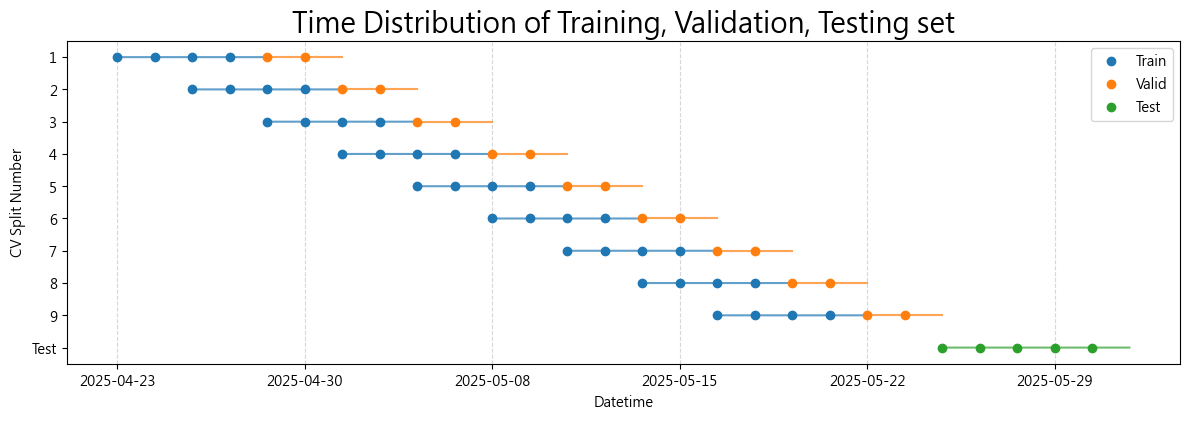

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
minutes_per_day = 266  # 每天的資料點數（例如：每分鐘1筆，共266分鐘）
cv_splits = get_cv().get_n_splits()

for j, (train_idx, valid_idx) in enumerate(get_cv().get_cv_time_idx(), start=1):
    i = get_cv().get_n_splits() - j  # 反向索引，從最後一組開始畫
    # 只取每天一個點（每266筆抓一次）
    train_points = [i for i in train_idx if i % minutes_per_day == 0]
    valid_points = [i for i in valid_idx if i % minutes_per_day == 0]

    # 畫 train（藍色圓點+線線）
    ax.plot(train_points, [i] * len(train_points), 'o', color='tab:blue', label='Train' if i == 0 else "")
    ax.plot(train_idx, [i] * len(train_idx), '-', color='tab:blue', alpha=0.7)

    # 畫 valid（橘色圓點＋線）
    ax.plot(valid_points, [i] * len(valid_points), 'o', color='tab:orange', label='Valid' if i == 0 else "")
    ax.plot(valid_idx, [i] * len(valid_idx), '-', color='tab:orange', alpha=0.7)

test_idx = get_cv().get_test_time_idx()
test_points = [i for i in test_idx if i % minutes_per_day == 0]

ax.plot(test_points, [-1] * len(test_points), 'o', color='tab:green', label='Test')
ax.plot(test_idx, [-1] * len(test_idx), '-', color='tab:green', alpha=0.7)

# 設定 x 軸標籤：每5天（5 × 266）
xticks = np.arange(0, max(test_idx), 5 * minutes_per_day)
ax.set_xticks(xticks)
ax.set_xticklabels(get_cv().get_times()[xticks].date)
ax.set_xlabel("Datetime")

# 設定 Y 軸順序倒轉
yticks = list(range(-1,cv_splits))
ax.set_yticks(yticks)
ax.set_yticklabels(['Test']+[(cv_splits - i) for i in yticks if i>=0])
ax.set_ylim(-0.5 -1, cv_splits - 0.5)
ax.set_ylabel("CV Split Number")

ax.legend()
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.title("Time Distribution of Training, Validation, Testing set", fontsize=20)
plt.show()

## Model Training --LightGBM

- Use `LightGBM` library to train LightGBM model to predict forward returns.

- Use `Optuna` library to efficiently optimize and select the best model parameters.

- Reference: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/11_intraday_model.ipynb

### Customized Function for `LightGBM` Model

- Create a customized training function for flexible inputs and objectives.

- Use RMSE as the primary evaluation and early stopping metric, with a customed IC (Information Coeffecient) metric used as a supplementary reference metric.

- Saved the IC median stat and FI (Feature Importance) ratio of each model boosting rounds.

- ***NOTE***: 
    - **RMSE**: Default evaluation metric, used for monitoring the validation performance during training and serves as the criterion for early stopping.
    - **IC**: Reference metric, evaluate the correlation between predictions and true values, helping detect potential overfitting by comparing IC scores between training and validation sets.
    - **IC median stat**: Customed evaluation metric, the median of per-minute IC values within each fold, followed by taking the median across all validation folds, used as the optimization objective during Optuna hyperparameter tuning.


In [15]:
# Custom Metric，evaluate model
from scipy.stats import spearmanr

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    y_true = train_data.get_label()
    if np.std(preds) == 0 or np.std(y_true) == 0:
        return 'ic', 0.0, True  # 避免 NaN
    return 'ic', spearmanr(preds, train_data.get_label(), nan_policy='omit')[0], is_higher_better

## Save Results of every final model in boosting
# ICs (Metric) for results (every boosting round)
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

# Feature Importance Ratio for results
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))



### Main Model Setting

- Configure the LightGBM model parameters.

- Output the IC metric and feature importance for each CV process.

- Compute the predicted values for each result and calculate the per-minute correlation between actual and predicted values (IC stat).

In [16]:
# 交叉驗證訓練模型設定

def fit_lgb_cv(lgb_params, target, data=stocks1, num_boost_round=300, debug=False):

  # start = dt.datetime.now()  
  
  # save all IC scores (per boosting), median IC (groupby minutes), feature importance, predicted data for each folds
  # IC metric (IC scores): 每個boosting round一個值，會持續改進（其餘stat都只輸出final model的值）
  # IC stat (median IC): 計算每分鐘各ticker的實際/預測corr coef.，再取所有時間的中位數
  all_ic_metric = []
  all_ic_stat = []
  all_fi = []
  all_preds = []

  for fold, (train_times, valid_times) in enumerate(get_cv(DATA=data).split(), 1):
    
    # create lgb train set
    train_set = data.loc[train_times, :].drop(delete_col, axis=1) #去掉非int, float, bool的欄位
    lgb_train = lgb.Dataset(data=train_set.drop(ret_col, axis=1),
                            label=train_set[target],
                            categorical_feature='stock_encoded')
    
    # create lgb valid set
    valid_set = data.loc[valid_times, :].drop(delete_col, axis=1)
    lgb_valid = lgb.Dataset(data=valid_set.drop(ret_col, axis=1),
                          label=valid_set[target],
                          categorical_feature='stock_encoded', 
                          reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=lgb_params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_valid],
                    #   valid_names=valid_names,
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      callbacks=[
                        # boosting過程若50輪之後IC仍未增加min_delta（使用預設值=0），則提前終止
                        lgb.early_stopping(stopping_rounds=50, verbose=False),  
                        lgb.record_evaluation(evals_result),
                        lgb.log_evaluation(period=0)
                        ]
                    #   evals_result=evals_result,
                    #   verbose_eval=50
                      )
    
    ### Save IC metric and Feature importance
    # get train/valid ic scores (of every boosting round)
    scores = get_scores(evals_result)
    all_ic_metric.append(scores)

    # get feature importance (of final model)
    fi = get_fi(model)  
    all_fi.append(fi)

    # generate validation predictions
    valid_X = valid_set.loc[:, model.feature_name()]
    valid_y = valid_set.loc[:, [target]]
    valid_y['pred'] = model.predict(valid_X)
    all_preds.append(valid_y)

    # compute average IC of all minutes (per fold)
    by_minute = valid_y.groupby(valid_set.index.get_level_values('date'))  # IC per minute (of all tickers)
    ic_stat = by_minute.apply(lambda x: spearmanr(x[target], x.pred)[0]).median()  # median IC of all minutes 
    all_ic_stat.append(ic_stat)

    # m, s = divmod((dt.datetime.now()-start).total_seconds(), 60)
    # h, m = divmod(m, 60)

    # print(f'\nFold: {fold:02} | {int(h):02}:{int(m):02}:{s:05.2f} | IC per minute: {daily_ic:.2%}\n')

    if debug:
      break  # debug 模式只跑 1 fold
    
  return dict(all_ic_metric=all_ic_metric, all_preds=all_preds, all_ic_stat=np.median(all_ic_stat), all_fi=all_fi), model  #np.median(all_daily_ic)


### Tuning Parameters by `Optuna`

- Define fixed parameters for the LightGBM model and specified the search space for hyperparameter optimization.

- Optimize the model to maximize the median of the IC median stat (i.e., the correlation coefficient between actual and predicted values per minute), and save the model result with the best IC median performance.












In [17]:
MODEL_PATH = 'c:\\python_vs\\strategy\\hft_1\\lgb'

In [18]:
# optuna調參（lightgbm原生支援，不需需再用grid cv!!!）

def objective(trial, target, NUM_BOOST_ROUND):
    # 定義要優化的超參數
    lgb_params = {
        'seed': 320,
        'objective': 'regression',
        'metric': ['rmse'],  # 以此做boosting的early stopping 、輸出 log，IC metric只用來顯示，IC median by minute是用來tune
        'verbosity': -1,  #可消除擾人的 WARNING "[LightGBM] [Warning] No further splits with positive gain, best gain: -inf"
        # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
        'boosting_type': 'gbdt',
        'gpu_use_dp' : False,
        'learning_rate': trial.suggest_float('learning_rate', 0.00005, 0.2, log=True), #用log-uniform抽（而非線性取樣）可能的學習率
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0000001, 1, log=True),  #Lasso
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0000001, 1, log=True),  #Ridge
    }

    # CV model fit
    res, model = fit_lgb_cv(lgb_params, target, data=stocks1, num_boost_round=NUM_BOOST_ROUND, debug=False)

    # 自動建立資料夾
    os.makedirs(f'{MODEL_PATH}\\{target}\\best_model', exist_ok=True)
    
    # 儲存最佳模型與附加結果（ic_metric, pred data, fi)
    if trial.number == 0 or res['all_ic_stat'] > trial.study.best_value:

        model.save_model(f'{MODEL_PATH}\\{target}\\best_model\\model_{trial.number:02}.txt')

        # save validation predictions
        pd.concat(res['all_preds'], axis=0).to_hdf(f'{MODEL_PATH}\\{target}\\res.h5', key = f'preds/{trial.number:02}')

        # save feature importance
        pd.concat(res['all_fi'], axis=1).to_hdf(f'{MODEL_PATH}\\{target}\\res.h5', key = f'fi/{trial.number:02}')
    
    # 回傳驗證集的IC (by folds, groupby minutes)，作為調參指標依據
    return res['all_ic_stat']

# res, model = fit_lgb_cv(lgb_params=lgb_params, target=ret_col[0], data=stocks1, num_boost_round=50)
# res['all_ic_metric_mean'][1]
# pd.concat(res['all_preds'], axis=0)
# res['all_ic_stat']

### Additional Setting (early stopping, progressor bar)

Implement an early stopping function and added a progress bar to monitor the optimization process in real time

In [19]:
# 自定義 Early Stopping callback（避免浪費時間做無意義的parameter tuning）
class NoProgressEarlyStopper:
    def __init__(self, patience=10, min_delta=0.01):  # patience: trial個數，min_delta: 可忍受的範圍，預設為0.01（即10次trial內IC增加不到1%就停止）
        self.patience = patience
        self.min_delta = min_delta
        self.best = -float('inf')
        self.counter = 0

    def __call__(self, study, trial):
        if trial.value > self.best + self.min_delta:
            self.best = trial.value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"\n⛔Early stopping⛔: No IC improvement > {self.min_delta} for {self.patience} trials.\n")
            study.stop()

# 製作進度條
class TQDMCallback:
    def __init__(self, total, desc='Optuna'):

        self.pbar = tqdm(total=total, desc=desc)
        self.last_time = time.time()

    def __call__(self, study, trial):
        elapsed = time.time() - self.last_time
        self.pbar.set_postfix({   # 進度條旁邊要放的敘述
            'Trial': trial.number,
            'IC': f"{trial.value:.4f}" if trial.value else 'None',
            'Best_IC': f"{study.best_value:.4f}" if study.best_value else 'None',
            'Elapsed': f"{elapsed:.1f}s"
        })
        self.pbar.update(1)
        self.last_time = time.time()

    def close(self):
        self.pbar.close()

### Run Models

- Train and optimize models separately for the expected returns over the next 1, 3, 5, and 10 minutes.

- Perform up to 50 rounds of hyperparameter tuning, with early stopping if the IC median don't improve by more than 0.005 for 10 consecutive rounds.

- Conduct up to 200 boosting iterations per cross-validation fold, with early termination if the IC metric don't improve over 50 consecutive iterations.

- Return a progress bar and reported the IC metric and RMSE for the final boosting result of each CV fold (NOTE: RMSE is just for reference and not used as the boosting evaluation metric)











In [ ]:
N_TRIALS=50  # optuna試驗次數（試驗參數組合個數）
from optuna.samplers import TPESampler

for target in ret_col:
    print(f'\n🎯 Tuning {target}')
    study = optuna.create_study(direction='maximize', 
                                sampler=TPESampler(seed=320))  # 設定隨機種子
    
    tqdm_cb = TQDMCallback(total=N_TRIALS, desc=f"Tuning {target}")

    # 若IC median已10輪未超過最佳IC+0.005，則提前終止試驗
    early_stopper = NoProgressEarlyStopper(patience=10, min_delta=0.005)   

    study.optimize(
        func=partial(objective, target=target, NUM_BOOST_ROUND=200),  # 每個CV內的boosting次數減少為200次，否則模型跑太慢
        n_trials=N_TRIALS,
        callbacks=[tqdm_cb, early_stopper]
    )

    tqdm_cb.close()

    # 儲存結果
    print(f'\n✅ Best IC for {target}: {study.best_value:.4f}')
    print(f'Best Params: {study.best_params}')
    # study.trials_dataframe().to_csv(f'{MODEL_PATH}\\{target}\\optuna_trials.csv')
    study.trials_dataframe().to_hdf(f'{MODEL_PATH}\\{target}\\optuna_trials_df_{target}.h5', key = f'30trial/{target}')
    joblib.dump(study, f"hft_1\\study_{target}.pkl")  # 暫存調參結果


[I 2025-06-18 14:33:16,768] A new study created in memory with name: no-name-e22fb9b5-6806-4b13-beb7-9d8c75517d8e



🎯 Tuning fwd_ret_1


Tuning fwd_ret_1:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 14:33:50,415] Trial 0 finished with value: 0.488050265690042 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.488050265690042.
[I 2025-06-18 14:34:35,978] Trial 1 finished with value: 0.4793660972613936 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.488050265690042.
[I 2025-06-18 14:35:24,487] Trial 2 finished with value: 0.4767124048826483 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178205452, 


⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_1: 0.4967
Best Params: {'learning_rate': 0.03571214181325229, 'num_leaves': 97, 'min_data_in_leaf': 10, 'feature_fraction': 0.882007900446725, 'bagging_fraction': 0.8236475356666716, 'bagging_freq': 3, 'lambda_l1': 0.0013071385227891878, 'lambda_l2': 6.074047902345328e-06}

🎯 Tuning fwd_ret_3


Tuning fwd_ret_3:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 14:47:38,107] Trial 0 finished with value: 0.46738187967705136 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.46738187967705136.
[I 2025-06-18 14:48:34,141] Trial 1 finished with value: 0.46413355070008155 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.46738187967705136.
[I 2025-06-18 14:49:29,529] Trial 2 finished with value: 0.44640672396790504 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178


⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_3: 0.4728
Best Params: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}

🎯 Tuning fwd_ret_5


Tuning fwd_ret_5:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 14:57:14,894] Trial 0 finished with value: 0.4678283391287636 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.4678283391287636.
[I 2025-06-18 14:58:06,556] Trial 1 finished with value: 0.4563694055688813 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.4678283391287636.
[I 2025-06-18 14:58:56,670] Trial 2 finished with value: 0.45663172145434383 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.75262931782054


⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_5: 0.4678
Best Params: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}

🎯 Tuning fwd_ret_10


Tuning fwd_ret_10:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 15:04:38,153] Trial 0 finished with value: 0.48611535728242994 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.48611535728242994.
[I 2025-06-18 15:05:21,216] Trial 1 finished with value: 0.47734035862091817 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.48611535728242994.
[I 2025-06-18 15:06:06,782] Trial 2 finished with value: 0.471721133974025 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.752629317820


⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_10: 0.4958
Best Params: {'learning_rate': 0.04854178874929791, 'num_leaves': 41, 'min_data_in_leaf': 412, 'feature_fraction': 0.7101422103373515, 'bagging_fraction': 0.740909578875623, 'bagging_freq': 8, 'lambda_l1': 1.0690638652036372e-07, 'lambda_l2': 5.202248543983376e-06}


In [ ]:
for target in ret_col:
    study = joblib.load(f"hft_1\\study_{target}.pkl")
    
    print(f'Label: {target}')
    print(f'Best Params: {study.best_params}')
    

Label: fwd_ret_1
Best Params: {'learning_rate': 0.03571214181325229, 'num_leaves': 97, 'min_data_in_leaf': 10, 'feature_fraction': 0.882007900446725, 'bagging_fraction': 0.8236475356666716, 'bagging_freq': 3, 'lambda_l1': 0.0013071385227891878, 'lambda_l2': 6.074047902345328e-06}
Label: fwd_ret_3
Best Params: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}
Label: fwd_ret_5
Best Params: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}
Label: fwd_ret_10
Best Params: {'learning_rate': 0.04854178874929791, 'num_leaves': 41, 'min_data_in_leaf': 412, 'feature_fraction': 0.7101422103373515, 

Label: fwd_ret_1


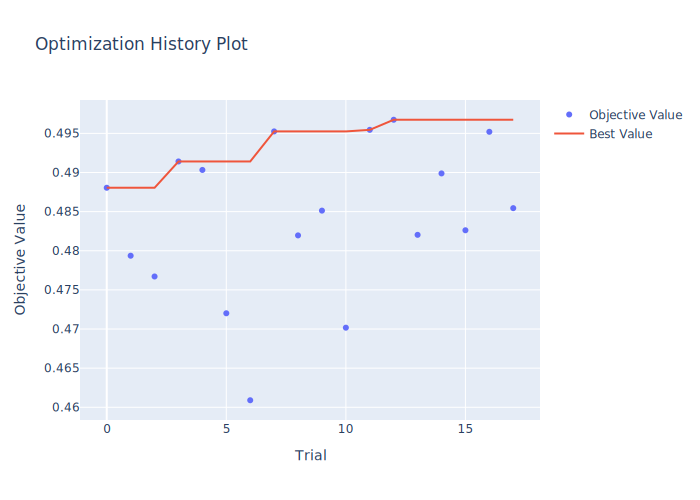

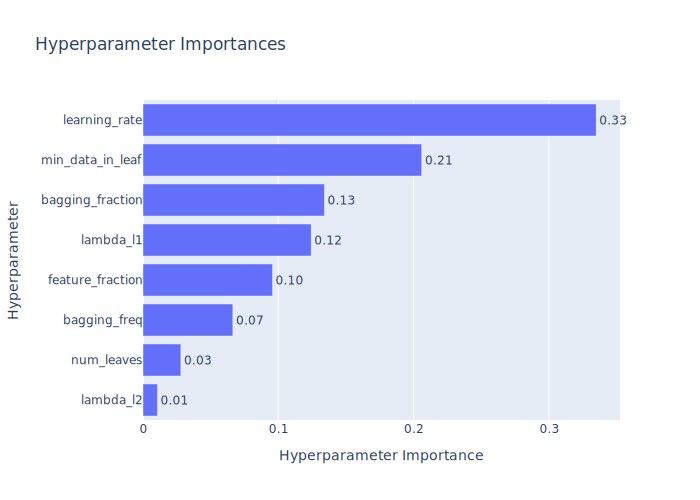

Label: fwd_ret_3


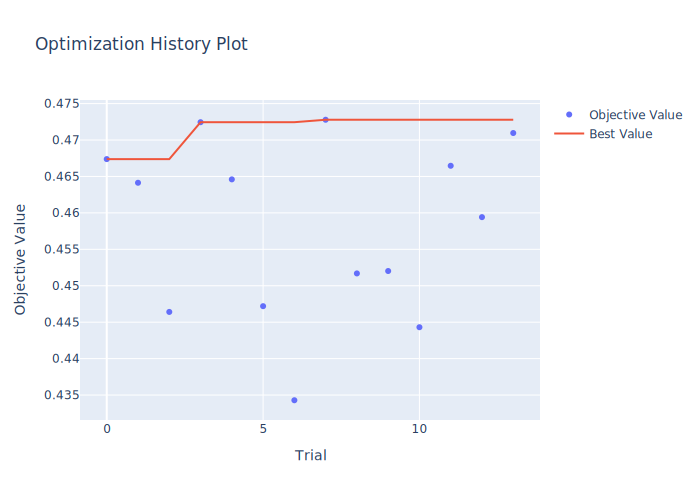

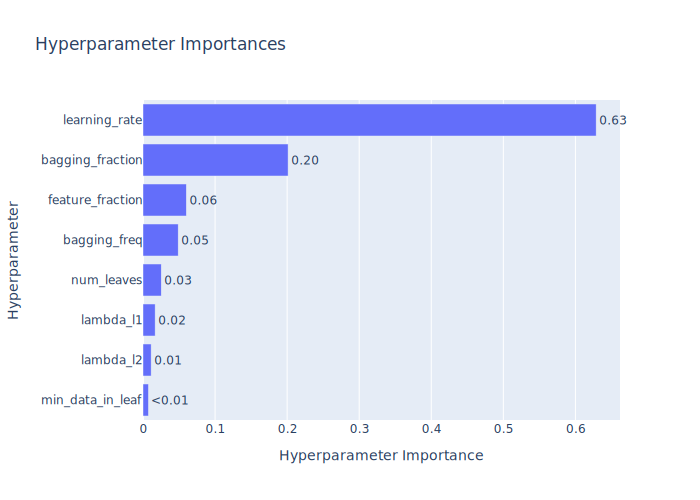

Label: fwd_ret_5


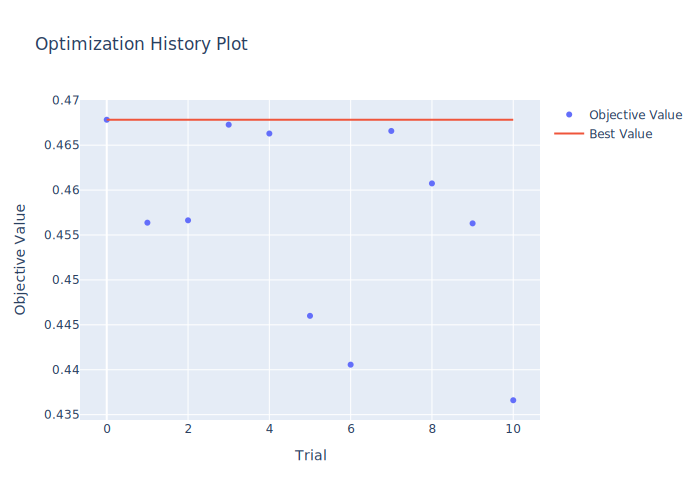

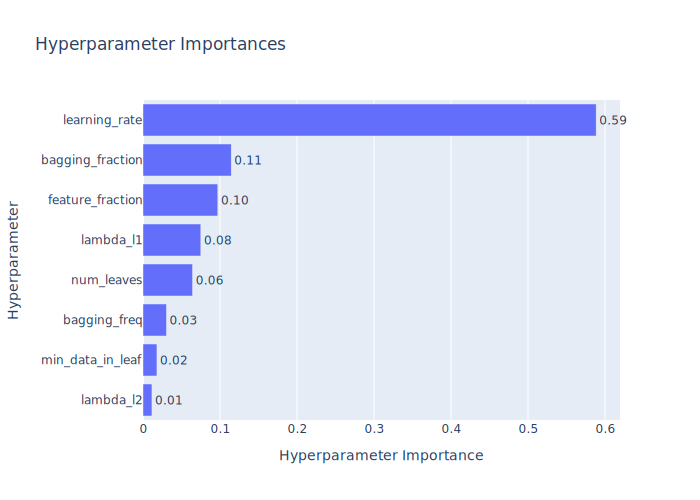

Label: fwd_ret_10


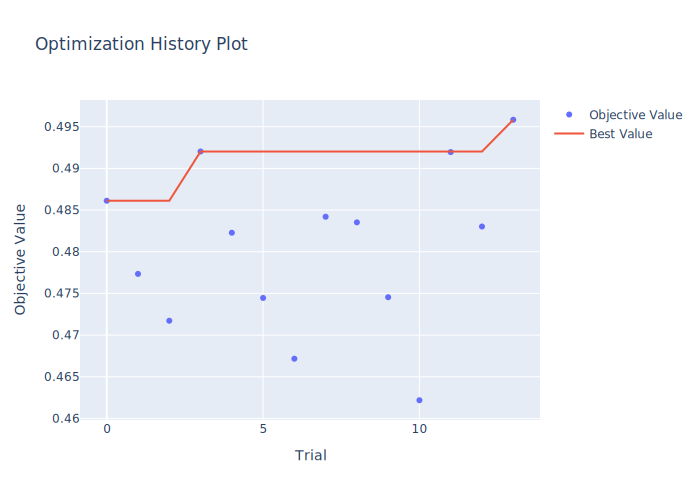

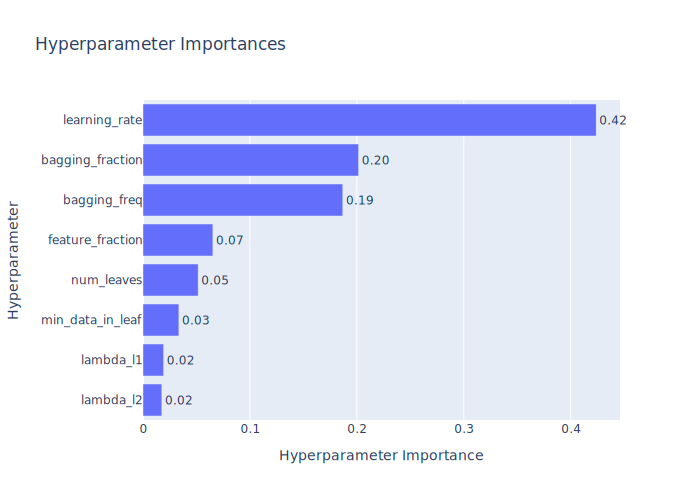

In [230]:
# res0 = pd.read_hdf(f'{MODEL_PATH}\\{target}\\optuna_trials_df_{target}.h5', key = f'50trial/{target}')
import optuna.visualization as vis

for target in ret_col:
    study = joblib.load(f"hft_1\\study_{target}.pkl")
    # 畫圖
    print(f'Label: {target}')

    show_plotly(vis.plot_optimization_history(study))   # fig_name=f'optuna_history_{target}'
    show_plotly(vis.plot_param_importances(study)) # fig_name=f'optuna_param_imp_{target}'

## Model Testing

Apply the best parameters from the final model to predict on the test set.

In [23]:
# 交叉驗證訓練模型設定

def fit_lgb_test(lgb_params, target, train_data, test_data, num_boost_round=300):

  # start = dt.datetime.now()  

  # save all IC scores (per boosting), median IC (groupby minutes), feature importance, predicted data for each folds
  # IC scores: 每個boosting round一個值，會持續改進
  # median IC: 計算每分鐘各ticker的實際/預測corr，再取所有時間的中位數
    
  # create lgb train, test set
  train_set = train_data.loc[:, ~train_data.columns.isin([delete_col])] #去掉非int, float, bool的欄位
  test_set = test_data.loc[:, ~test_data.columns.isin([delete_col])] 

  lgb_train = lgb.Dataset(data=train_set.drop(ret_col, axis=1),
                          label=train_set[target],
                          categorical_feature='stock_encoded')
  
  # train model (not need to valid now)
  evals_result={}
  model = lgb.train(params=lgb_params,
                    train_set=lgb_train,
                  #   valid_names=valid_names,
                    feval=ic_lgbm,
                    num_boost_round=num_boost_round,
                    callbacks=[
                      # lgb.early_stopping(stopping_rounds=50),
                      lgb.record_evaluation(evals_result)
                      ]
                  #   evals_result=evals_result,
                  #   verbose_eval=50
                    )
  
  # generate testing data predictions
  test_X = test_set.loc[:, model.feature_name()]
  test_y = test_set.loc[:, [target]]
  test_y['pred'] = model.predict(test_X)

  # get train/valid ic scores (during every boosting round, of all data)
  # scores = get_scores(evals_result)

  # compute IC of all minutes 
  by_minute = test_y.groupby(test_set.index.get_level_values('date'))  # IC per minute (of all tickers)
  ic_per_minute = by_minute.apply(lambda x: spearmanr(x[target], x.pred, nan_policy='omit')[0])  

  # get feature importance
  fi = get_fi(model)

  # m, s = divmod((dt.datetime.now()-start).total_seconds(), 60)
  # h, m = divmod(m, 60)

  # print(f'\nFold: {fold:02} | {int(h):02}:{int(m):02}:{s:05.2f} | IC per minute: {daily_ic:.2%}\n')

    
  return dict(preds=test_y, ic_stat=ic_per_minute, all_fi=fi), model  #np.median(all_daily_ic)


In [24]:
stocks1_test = get_cv(DATA=stocks1).get_test_data().drop(delete_col, axis=1)
stocks1_train = get_cv(DATA=stocks1).get_train_valid_data().drop(delete_col, axis=1)

test_res = {}
test_model = {}

fixed_params = {
        'seed': 32,
        'objective': 'regression',
        'metric': ['rmse'],
        'verbosity': -1,  #可消除擾人的 WARNING "[LightGBM] [Warning] No further splits with positive gain, best gain: -inf"
        'boosting_type': 'gbdt',
        'gpu_use_dp' : False}

### 把best_param放入lgb模型配適test data
for target in ret_col:
    study = joblib.load(f"study_{target}.pkl")
    final_params = {**fixed_params, **study.best_params}  # combine fixed params and tuned params
    test_res[f'{target}'], test_model[f'{target}'] = fit_lgb_test(lgb_params=final_params,
                                                                target=target,
                                                                train_data=stocks1_train, 
                                                                test_data=stocks1_test, 
                                                                num_boost_round=300)


### Feature Importance Plot

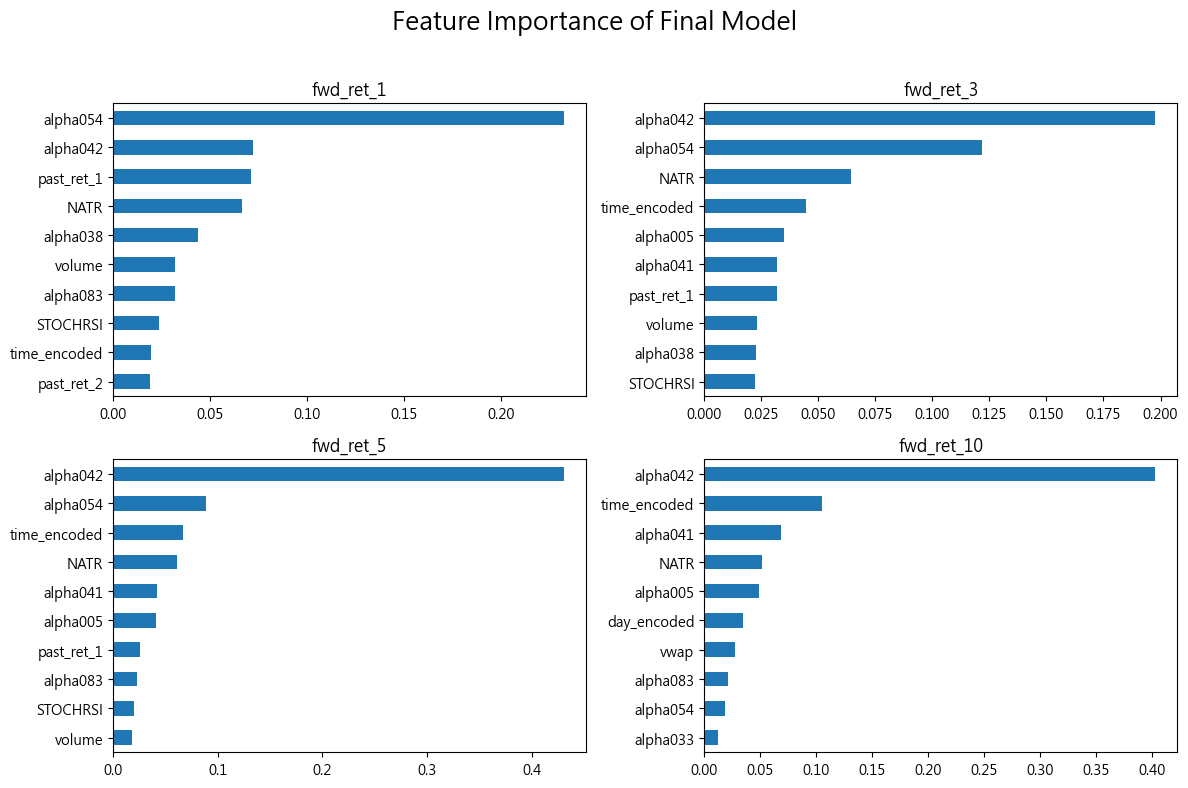

In [25]:
### fi bar plot

num_plots = len(ret_col)
fig, axes = plt.subplots(nrows=int(num_plots/2) , ncols=2, figsize=(12, 2 * num_plots))
                         
for idx, target in enumerate(ret_col):
    row, col = divmod(idx, 2)
    test_res[target]['all_fi'].sort_values(ascending=True).tail(10).\
        plot(kind='barh', title=f"{target}", ax = axes[row, col])

fig.suptitle('Feature Importance of Final Model', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [26]:
# target = ret_col[0] # fwd_ret_1
# yy = test_res[target]['preds'].copy()
# K = 12
# by_minute = yy.groupby(yy.index.get_level_values('date'), group_keys=False)
# yy['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=K, labels=list(range(1,K+1)), duplicates='raise').astype(int))
# def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
#     by_quantile = yy.reset_index().groupby(['date', quantile])
#     return by_quantile[target].mean().unstack(quantile).sort_index()   # 同時間不同ticker取mean

# intraday_returns = compute_intraday_returns_by_quantile(yy, quantile='decile')

# (intraday_returns.sort_index().add(1).sub(0.2/10000).cumprod().sub(1)).plot()

### SHAP Feature Importance

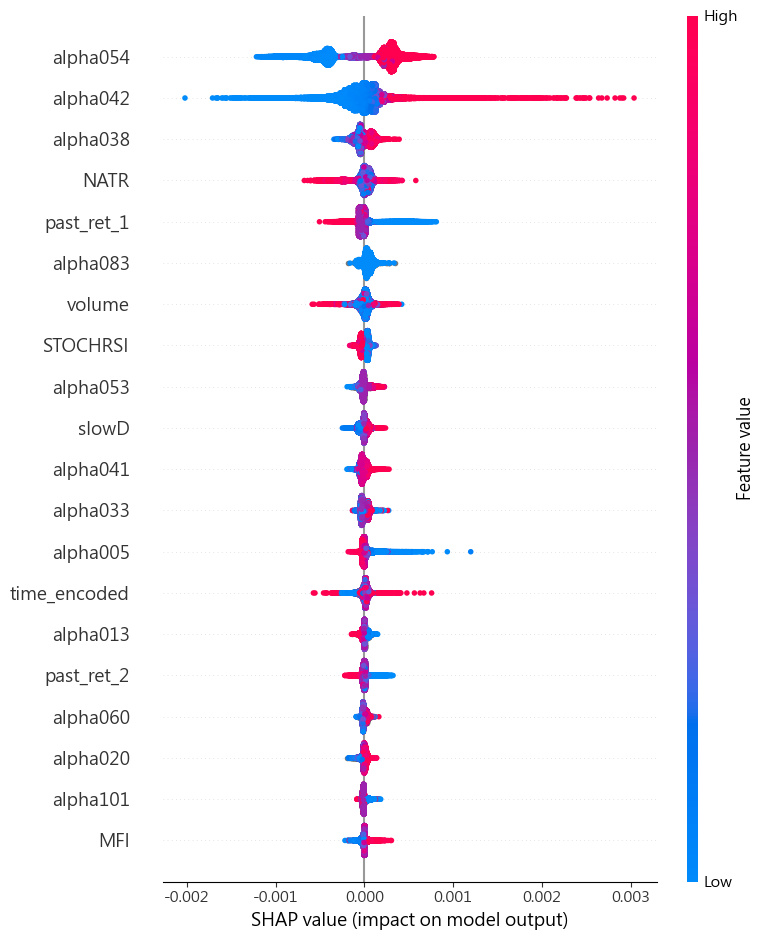

In [27]:
### SHAP fi plot
explainer = shap.TreeExplainer(test_model['fwd_ret_1'])
shap_values = explainer.shap_values(stocks1_test.drop(ret_col, axis=1) )
shap.summary_plot(shap_values, stocks1_test.drop(ret_col, axis=1))

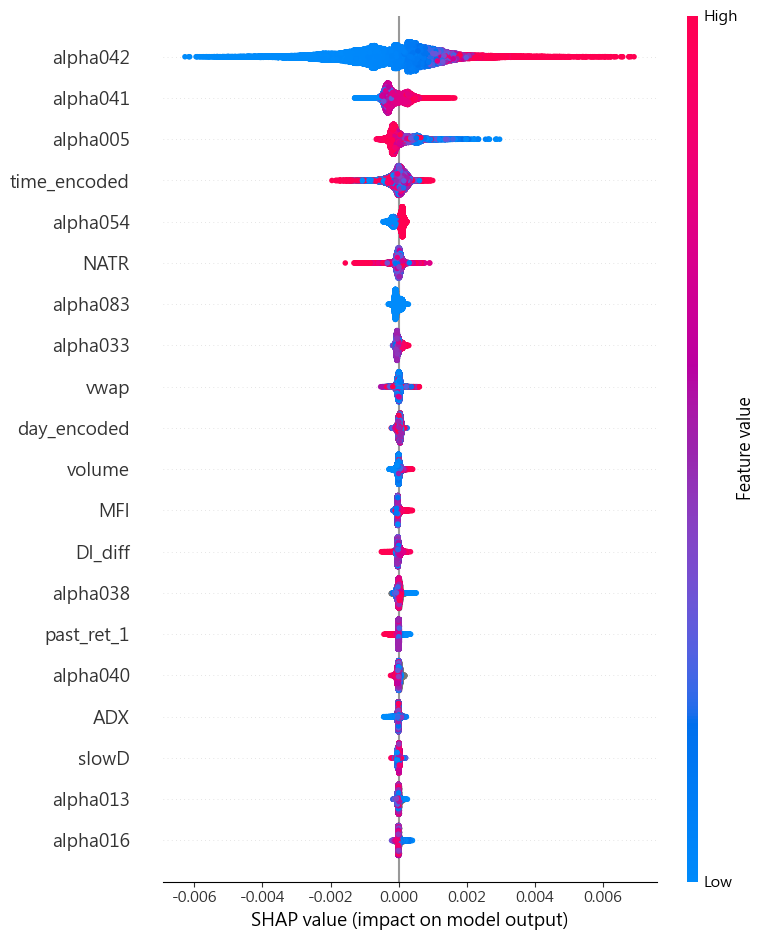

In [28]:
### SHAP fi plot (fwd_ret_10)
explainer = shap.TreeExplainer(test_model['fwd_ret_10'])
shap_values = explainer.shap_values(stocks1_test.drop(ret_col, axis=1) )
shap.summary_plot(shap_values, stocks1_test.drop(ret_col, axis=1))

### Forward Returns Forecasting

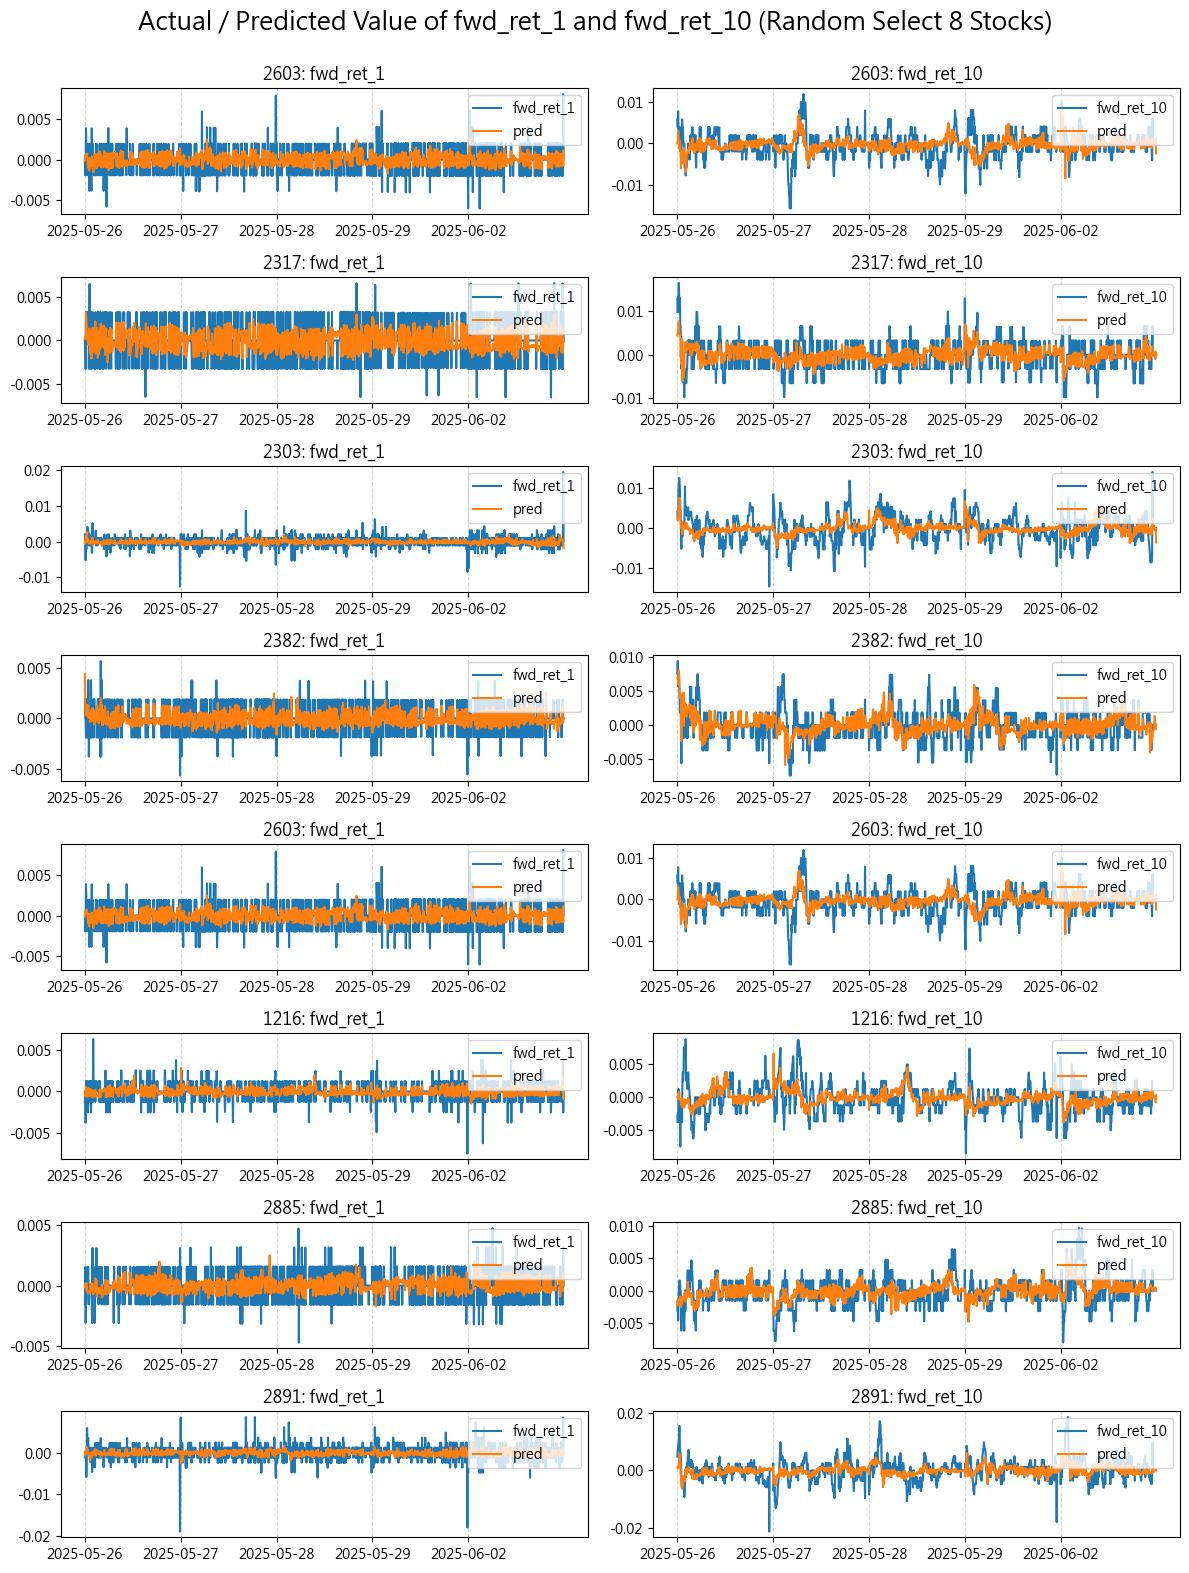

In [29]:
np.random.seed(320)
n = 8
# tickers_random = random.sample(tickers, n)
tickers_random = np.random.choice(tickers, n)
targets = ['fwd_ret_1', 'fwd_ret_10']
fig, axes = plt.subplots(nrows = n , ncols = len(targets) , figsize=(6 * len(targets), 2 * n))

for i, ticker in enumerate(tickers_random):
    for idx, target in enumerate(targets):
        row = i
        col = idx % len(targets)

        preds_ticker=test_res[target]['preds'].query(f"ticker=='{ticker}'").copy().reset_index(level=1, drop=True)
        first_of_day = preds_ticker.groupby(preds_ticker.index.date).head(1).index
        first_of_day_idxnum = preds_ticker.index.get_indexer(first_of_day)
        first_of_day_label = preds_ticker.index[first_of_day_idxnum].date
        preds_ticker.reset_index(drop=True, inplace=True)

        plott = preds_ticker.plot(title = f'{ticker}: {target}', ax = axes[row, col])
        plott.set_xticks(first_of_day_idxnum)
        plott.set_xticklabels(first_of_day_label)
        plott.legend(loc = 'upper right')
        plott.grid(True, axis='x', linestyle='--', alpha=0.5)
    
fig.suptitle(f'Actual / Predicted Value of fwd_ret_1 and fwd_ret_10 (Random Select {n} Stocks)', fontsize=18)
plt.tight_layout(rect = [0,0,1,0.98])
plt.show()


### Box Plots of Actual / Predicted forward Returns

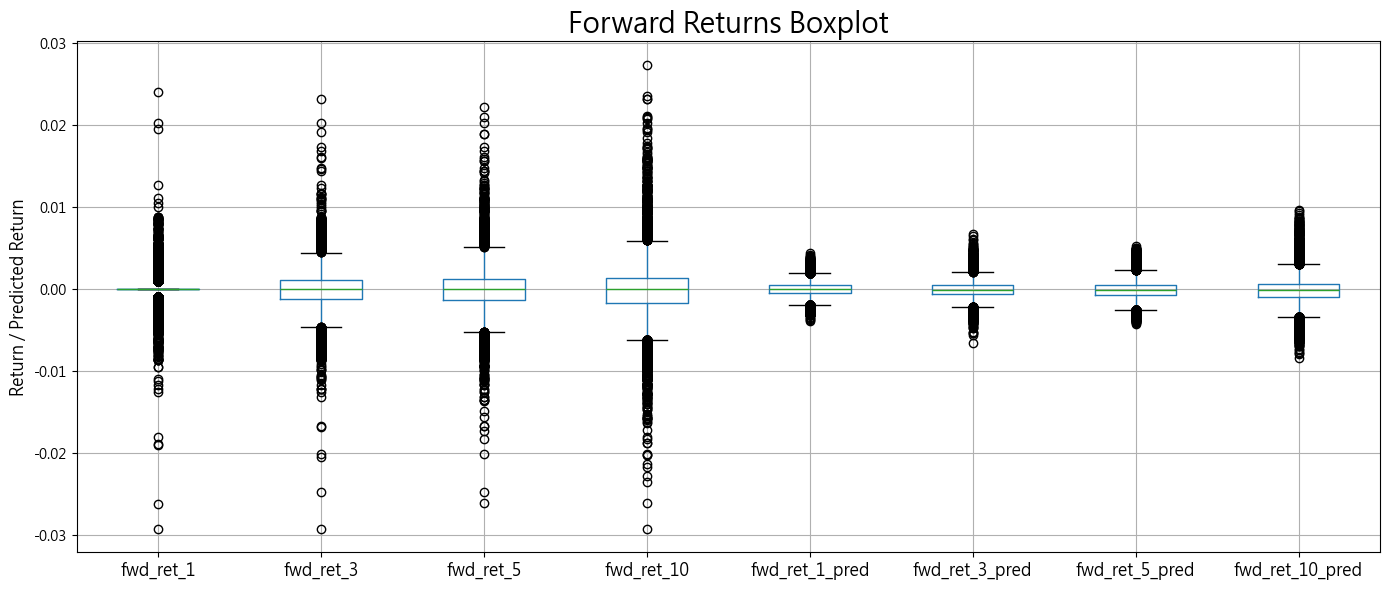

In [30]:
# reload test data
stocks1_test = get_cv(DATA=stocks1).get_test_data().copy()

# 將預測結果與測試集合併
for target in ret_col:
    stocks1_test.loc[:,f'{target}_pred'] = test_res[target]['preds']['pred'].reindex(stocks1_test.index)  

ret_col2 = stocks1_test.filter(regex='fwd_ret').columns  # 未來報酬率+預測的未來報酬率column

# 繪製未來報酬率與其預測值的Box Plot
plt.figure(figsize=(14, 6))  

stocks1_test[ret_col2].boxplot()

# 調整 X 軸文字角度與大小
plt.xticks(rotation=0, fontsize=12)

# 調整標題與座標軸字體大小
plt.title("Forward Returns Boxplot", fontsize=20)
plt.ylabel("Return / Predicted Return", fontsize=12)

plt.tight_layout()
plt.show()

## Backtesting

- Built trading strategies using both the `from_signals` and `from_order_func` methods from the `vectorbt.Portfolio` module.

- The backtesting primarily rely on the predicted future returns, with past returns and technical indicators used as supporting signals.

In [31]:
stocks1_test.head()

open    high     low   close  volume        vwap  \
date                ticker                                                      
2025-05-26 09:00:00 1216     79.9   79.90   79.70   79.70   223.0   79.766667   
                    2207    621.0  622.00  621.00  621.00    12.0  621.333333   
                    2303     47.8   48.05   47.65   48.05  3064.0   47.916667   
                    2308    374.0  374.00  371.00  372.00   116.0  372.333333   
                    2317    152.5  153.00  151.50  152.00  1782.0  152.166667   

                            alpha002  alpha003  alpha005  alpha006  ...  \
date                ticker                                          ...   
2025-05-26 09:00:00 1216         0.0       0.0 -0.729323       0.0  ...   
                    2207         0.0       0.0 -0.180451       0.0  ...   
                    2303         0.0       0.0 -0.601504       0.0  ...   
                    2308         0.0       0.0 -0.703008       0.0  ...   
                    2317         0.0       0.0 -0.033835       0.0  ...   

                                slowK      slowD      NATR        ADX  \
date                ticker                                              
2025-05-26 09:00:00 1216    44.444444  55.555556  0.151297  27.297720   
                    2207    66.666667  73.333333  0.304840  30.755895   
                    2303    26.111111  25.370370  0.257650  46.949989   
                    2308    59.523810  69.841270  0.225562  23.587404   
                    2317    56.666667  63.333333  0.460529  49.666054   

                              DI_diff      OBV  fwd_ret_1_pred  \
date                ticker                                       
2025-05-26 09:00:00 1216   -11.071725  12880.0        0.000049   
                    2207   -23.695994    318.0        0.003430   
                    2303   -52.260905  98439.0       -0.000477   
                    2308   -17.271014  15351.0        0.000558   
                    2317   -31.496645  41279.0        0.000197   

                            fwd_ret_3_pred  fwd_ret_5_pred  fwd_ret_10_pred  
date                ticker                                                   
2025-05-26 09:00:00 1216          0.001219       -0.000474    -8.804182e-07  
                    2207          0.005175        0.004640     6.929845e-03  
                    2303          0.000682        0.000963     2.780153e-03  
                    2308          0.001634        0.000459     2.471541e-03  
                    2317          0.001374        0.003249     4.400980e-03  

[5 rows x 70 columns]

In [32]:
stocks1_test.columns  

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'alpha002',
       'alpha003', 'alpha005', 'alpha006', 'alpha007', 'alpha011', 'alpha012',
       'alpha013', 'alpha015', 'alpha016', 'alpha018', 'alpha020', 'alpha027',
       'alpha030', 'alpha033', 'alpha038', 'alpha040', 'alpha041', 'alpha042',
       'alpha044', 'alpha050', 'alpha051', 'alpha053', 'alpha054', 'alpha060',
       'alpha083', 'alpha101', 'day', 'time', 'stock_encoded', 'day_encoded',
       'time_encoded', 'close_10min', 'close_20min', 'open_10min',
       'open_20min', 'past_ret_1', 'past_ret_2', 'past_ret_3', 'past_ret_4',
       'past_ret_5', 'past_ret_6', 'past_ret_7', 'past_ret_8', 'past_ret_9',
       'past_ret_10', 'fwd_ret_1', 'fwd_ret_3', 'fwd_ret_5', 'fwd_ret_10',
       'BOP', 'CCI', 'MFI', 'STOCHRSI', 'slowK', 'slowD', 'NATR', 'ADX',
       'DI_diff', 'OBV', 'fwd_ret_1_pred', 'fwd_ret_3_pred', 'fwd_ret_5_pred',
       'fwd_ret_10_pred'],
      dtype='object')

### from_signals

#### Strategy Design

- 訊號來源： 僅依賴「預測未來報酬率」（fwd_ret_t_pred，其中 t 為未來 t 分鐘）作為進出場依據，不使用其他複雜訊號或技術指標。

- 資金權重配置： 以各股票當下的 **VWAP（成交量加權平均價）**進行L1正規化，作為資金配置比例。→ 此設計使最終下單股數大致均分。

- 倉位調整邏輯：

    - 進場條件： **fwd_ret_10_pred > 0.1%** 或 **fwd_ret_5_pred > 0.2%**

    - 出場條件： **fwd_ret_10_pred < 0.2%**

- 風控機制：

    - 停損門檻為 **2%**

    - 若部位價格自最高點回落超過 2%，即觸發停損

    - 不設停利條件，讓獲利持續延伸

- 資金與交易限制： 

    - 全部股票共用資金池，並**允許部分下單**，提高資金使用效率。

    - 僅允許**整數股數**下單，單筆下單最少 1 股，最多 2,000 股

    - 初始資金： 1,000,000 元

    - 手續費：每筆交易 **0.1425%**

    - 滑價：每筆交易另計 **0.1%** 滑價





#### Setting

In [33]:
# stocks1_test 已經是 MultiIndex (date, stock)，close 為收盤價
df = stocks1_test.copy()

close = df['close'].unstack()
pred5 = df['fwd_ret_5_pred'].unstack()
pred10 = df['fwd_ret_10_pred'].unstack()

# 進場訊號條件（buy / sell）
buy_signal = (pred10 > 0.001)| (pred5>0.002)#| (pred3.gt(pred5).gt(pred10))# #| (pred3.gt(pred5).gt(pred10))# & (close < bb_lower)
sell_signal = (pred10 < -0.002)# | (pred10.lt(pred5).lt(pred3).lt(0))# # | (pred10.lt(pred5).lt(pred3).lt(0)) #& (close > bb_upper)

INIT_CASH = 1_000_000

# 權重
# weight = (df['alpha042'].unstack() / df['close'].unstack()).transform(lambda x: x/sum(x), axis=1)

# # VWAP 權重 (normalized)
weight = (df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).fillna(0)

position_amount = INIT_CASH * weight / close  # 每格股數配置（大致均分）

# position_amount

In [34]:
# 建立 Portfolio
pf_signal = vbt.Portfolio.from_signals(
    close,
    entries=buy_signal,  # 轉為 numpy 給 numba
    exits=sell_signal,
    size=position_amount ,
    # size=vwap_weight,
    init_cash=INIT_CASH,
    freq='1min',
    cash_sharing=True,  # 啟用資金共享
    call_seq='reversed',  # 叫價序列類型（auto-自動決定；random-隨機；default-買方優先；reversed-賣方優先）
    accumulate=True,  # 已有持倉的情況下是否累積（False-訊號不可累積，True-可加碼累積及部分平倉）
    allow_partial=True, # 是否允許部分資金下單
    sl_stop=0.02,  # 停損比例（跌超過多少比例就平倉）
    sl_trail=True,  # 移動停損（最高點回落就平倉停損）
    fees=0.001425,  # 手續費
    slippage=0.001,  # 滑價比例（實際成交價與理想間的差異）
    upon_opposite_entry='close',  # 遇到相反信號時關閉持倉
    size_type="Amount", 
    # size_type='Percent',
    # Amount:固定股數；Value：投入金額；Percent：投入金額的比例（隨總額變化）；TargetPercent (from_order才可用)：讓標的的金額比例在隨著時間變化時平衡回目標比例
    min_size=1,  # 最小交易單位
    max_size=2000,
    size_granularity=1,  # 交易單位間隔
    direction="longonly",
    group_by=True,
    update_value=True,  # 總資金是否隨時更新，預設就是True，但對size_type="value"沒用（因為已事先決定投入金額）
    # tp_stop=0.05,
)

# 若以vwap當標的，size選擇value，則投入股數會是vwap_weight * init_cash /close，但即便收益增加，分配到的金額還是會一樣
# 若size選擇percent，則投入股數會是vwap_weight * "remain_cash" /close ，因此訂單愈晚處理分配到的金額愈少
# BBANDS因高頻標準差較不准不太適合、RSI要搭配成交量使用比較適合

# HFT: 交易頻率低、交易量大、分批進出場、寬鬆止盈止損、提高勝率(最重要!!!)
# 想法：限制最小成交量/價（以降低次數）、最小持倉時間(可能有好有壞?)、思考延遲的部分（maybe跟滑價選一個就好）
# maybe開收盤的進出場條件設不一樣可以優化

# 我希望from_order_func能做到的：
## 1. 開收盤條件強化（進場條件較嚴格，收盤可考慮）
## 2. 根據更多條件設定加碼、停損出場
## 3. 務必做到隨時按收益調整總資金及各成分股的投入金額（比例）
## 3-1 每個時間點調整一次並且"不要"像size_type='percent'那樣同個時間點先處理股票號碼小的以致權重失衡
## 4. 棄用vwap作為投資組合權重，還沒想到適合的，maybe用close、等權、預期報酬率加權

#### Table Results

In [35]:
pf_signal.stats()

Start                               2025-05-26 09:00:00
End                                 2025-06-02 13:30:00
Period                                  0 days 22:10:00
Start Value                                   1000000.0
End Value                                1068582.442404
Total Return [%]                               6.858244
Benchmark Return [%]                           -1.89655
Max Gross Exposure [%]                        99.999966
Total Fees Paid                            42219.999696
Max Drawdown [%]                               1.523718
Max Drawdown Duration                   0 days 05:08:00
Total Trades                                        808
Total Closed Trades                                 787
Total Open Trades                                    21
Open Trade PnL                              10615.91391
Win Rate [%]                                  56.797967
Best Trade [%]                                 2.109549
Worst Trade [%]                               -3

In [36]:
print(f"Alpha: {pf_signal.alpha():.3e}, \nBeta: {pf_signal.beta():.4}")
# portfolio.asset_flow().loc[portfolio.asset_flow().apply(sum, axis=1)!=0]
# pf_signal.positions.values

Alpha: 5.126e+14, 
Beta: 0.9957


In [37]:
# 各檔個股下單次數
pf_signal.orders.records_readable.query('Side=="Buy"').groupby('Column').size()

Column
1216     58
2207     37
2303     61
2308     25
2317     69
2330     10
2345     30
2357     32
2382     56
2412    104
2454     81
2603     22
2880     34
2881     68
2882     78
2884     63
2885     49
2886     59
2891     93
2892    118
3045    106
3711     56
5880     49
6505     59
6669     43
dtype: int64

In [38]:
# 各檔個股出場次數

pf_signal.orders.records_readable.query('Side=="Sell"').groupby('Column').size()

Column
1216    38
2207    19
2303    29
2308    17
2317    36
2330     7
2345    10
2357    18
2382    30
2412    68
2454    30
2603    11
2880    24
2881    34
2882    50
2884    21
2885    10
2886    45
2891    46
2892    57
3045    82
3711    36
5880    21
6505    31
6669    17
dtype: int64

In [69]:
# 模型請求的訂單數據（不一定成交）
# pf_signal.asset_flow()
pf_signal.orders.records_readable.sort_values(by=['Column', 'Timestamp'], ascending=True)

,Order Id,Column,Timestamp,Size,Price,Fees,Side
252,252,1216,2025-05-26 11:10:00,57.0,78.8788,6.406931,Buy
261,261,1216,2025-05-26 11:13:00,1.0,78.8788,0.112402,Buy
272,272,1216,2025-05-26 11:18:00,117.0,78.8788,13.151068,Buy
277,277,1216,2025-05-26 11:19:00,117.0,78.8788,13.151068,Buy
282,282,1216,2025-05-26 11:20:00,117.0,78.8788,13.151068,Buy
...,...,...,...,...,...,...,...
2041,2041,6669,2025-06-02 10:14:00,3.0,2392.3900,10.227467,Buy
2077,2077,6669,2025-06-02 10:30:00,40.0,2407.5900,137.232630,Sell
2113,2113,6669,2025-06-02 11:59:00,2.0,2392.3900,6.818312,Buy
2193,2193,6669,2025-06-02 12:35:00,6.0,2392.3900,20.454935,Buy


In [70]:
# 實際成交的訂單數據（entry time跟exit time分別代表該訂單最早入倉的時間以及最晚清空倉位的時間）

# pf_signal.asset_flow()
pf_signal.trades.records_readable.sort_values(by=['Column', 'Entry Timestamp'], ascending=True)

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,1216,115.0,2025-05-26 11:10:00,79.967988,13.104754,2025-05-27 10:26:00,81.5184,13.358828,151.833839,0.016510,Long,Closed,0
1,1,1216,115.0,2025-05-26 11:10:00,79.967988,13.104754,2025-05-27 10:27:00,81.5184,13.358828,151.833839,0.016510,Long,Closed,0
2,2,1216,115.0,2025-05-26 11:10:00,79.967988,13.104754,2025-05-27 10:28:00,81.5184,13.358828,151.833839,0.016510,Long,Closed,0
3,3,1216,115.0,2025-05-26 11:10:00,79.967988,13.104754,2025-05-27 10:29:00,81.5184,13.358828,151.833839,0.016510,Long,Closed,0
4,4,1216,115.0,2025-05-26 11:10:00,79.967988,13.104754,2025-05-27 10:30:00,81.5184,13.358828,151.833839,0.016510,Long,Closed,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,803,6669,115.0,2025-05-29 13:30:00,2383.155969,390.539684,2025-06-02 09:07:00,2417.5800,396.180923,3172.042959,0.011574,Long,Closed,219
804,804,6669,115.0,2025-05-29 13:30:00,2383.155969,390.539684,2025-06-02 09:08:00,2427.5700,397.818034,4319.255848,0.015760,Long,Closed,219
805,805,6669,28.0,2025-05-29 13:30:00,2383.155969,95.087923,2025-06-02 09:09:00,2422.5750,96.660742,911.984203,0.013667,Long,Closed,219
806,806,6669,40.0,2025-06-02 09:44:00,2393.391000,136.423287,2025-06-02 10:30:00,2407.5900,137.232630,294.304083,0.003074,Long,Closed,220


#### Figure Results

In [207]:
datetime_order = pf_signal.wrapper.index
ticker_order = pf_signal.wrapper.columns

# 將圖片的x軸還原成原始資料日期（非交易時間不留白）
def fig_adj_xaxis(fig):
    first_of_day = [dt[0] for dt in datetime_order.groupby(datetime_order.date).values()]
    fig.update_layout(
        xaxis_type='category',
        xaxis=dict(tickmode='array',
                   tickvals=[datetime_order.get_loc(dt) for dt in first_of_day], 
                   ticktext=[dt.strftime('%Y-%m-%d') for dt in first_of_day], 
                   tickangle=0)
    )
    return fig
def fig_adj_xaxis_subplot(fig, subplot_idx):
    first_of_day = [dt[0] for dt in datetime_order.groupby(datetime_order.date).values()]

    xaxis_key = f'xaxis{subplot_idx}' if subplot_idx > 1 else 'xaxis'
    fig.update_layout({
        xaxis_key: dict(
            type='category',
            tickmode='array',
            tickvals=[datetime_order.get_loc(dt) for dt in first_of_day],
            ticktext=[dt.strftime('%Y-%m-%d') for dt in first_of_day],
            tickangle=30
        )
    })
    return fig


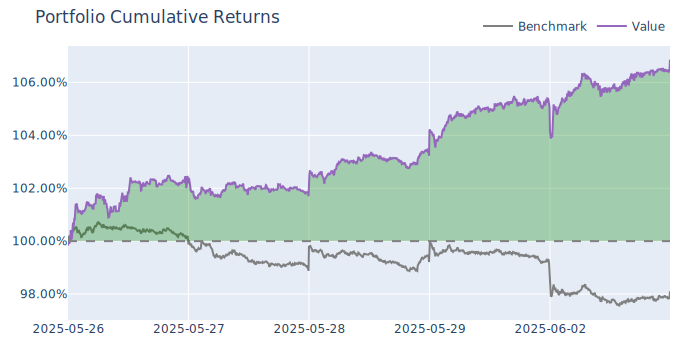

In [231]:
# import plotly.graph_objects as go
fig = pf_signal.plot_cum_returns(title='Portfolio Cumulative Returns')
# fig = go.Figure(fig)
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='signal_cum_ret'

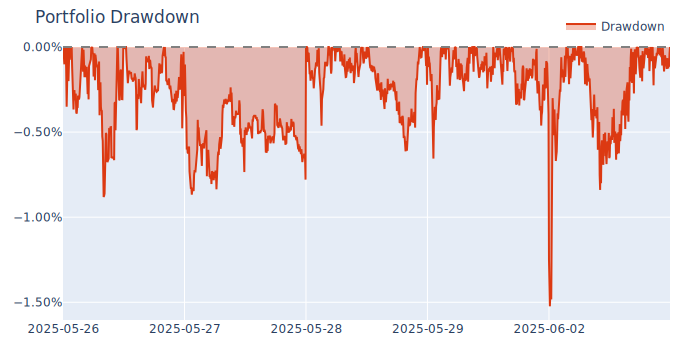

In [232]:
# 回撤深度（相對歷史高點跌幅）
fig = pf_signal.plot_underwater(title='Portfolio Drawdown')
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='signal_drawdown'

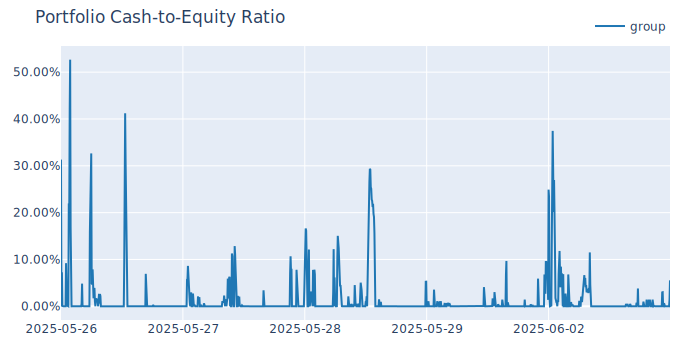

In [233]:
fig = (pf_signal.cash()/pf_signal.value()).vbt.plot(title='Portfolio Cash-to-Equity Ratio')
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='signal_cash2equity'

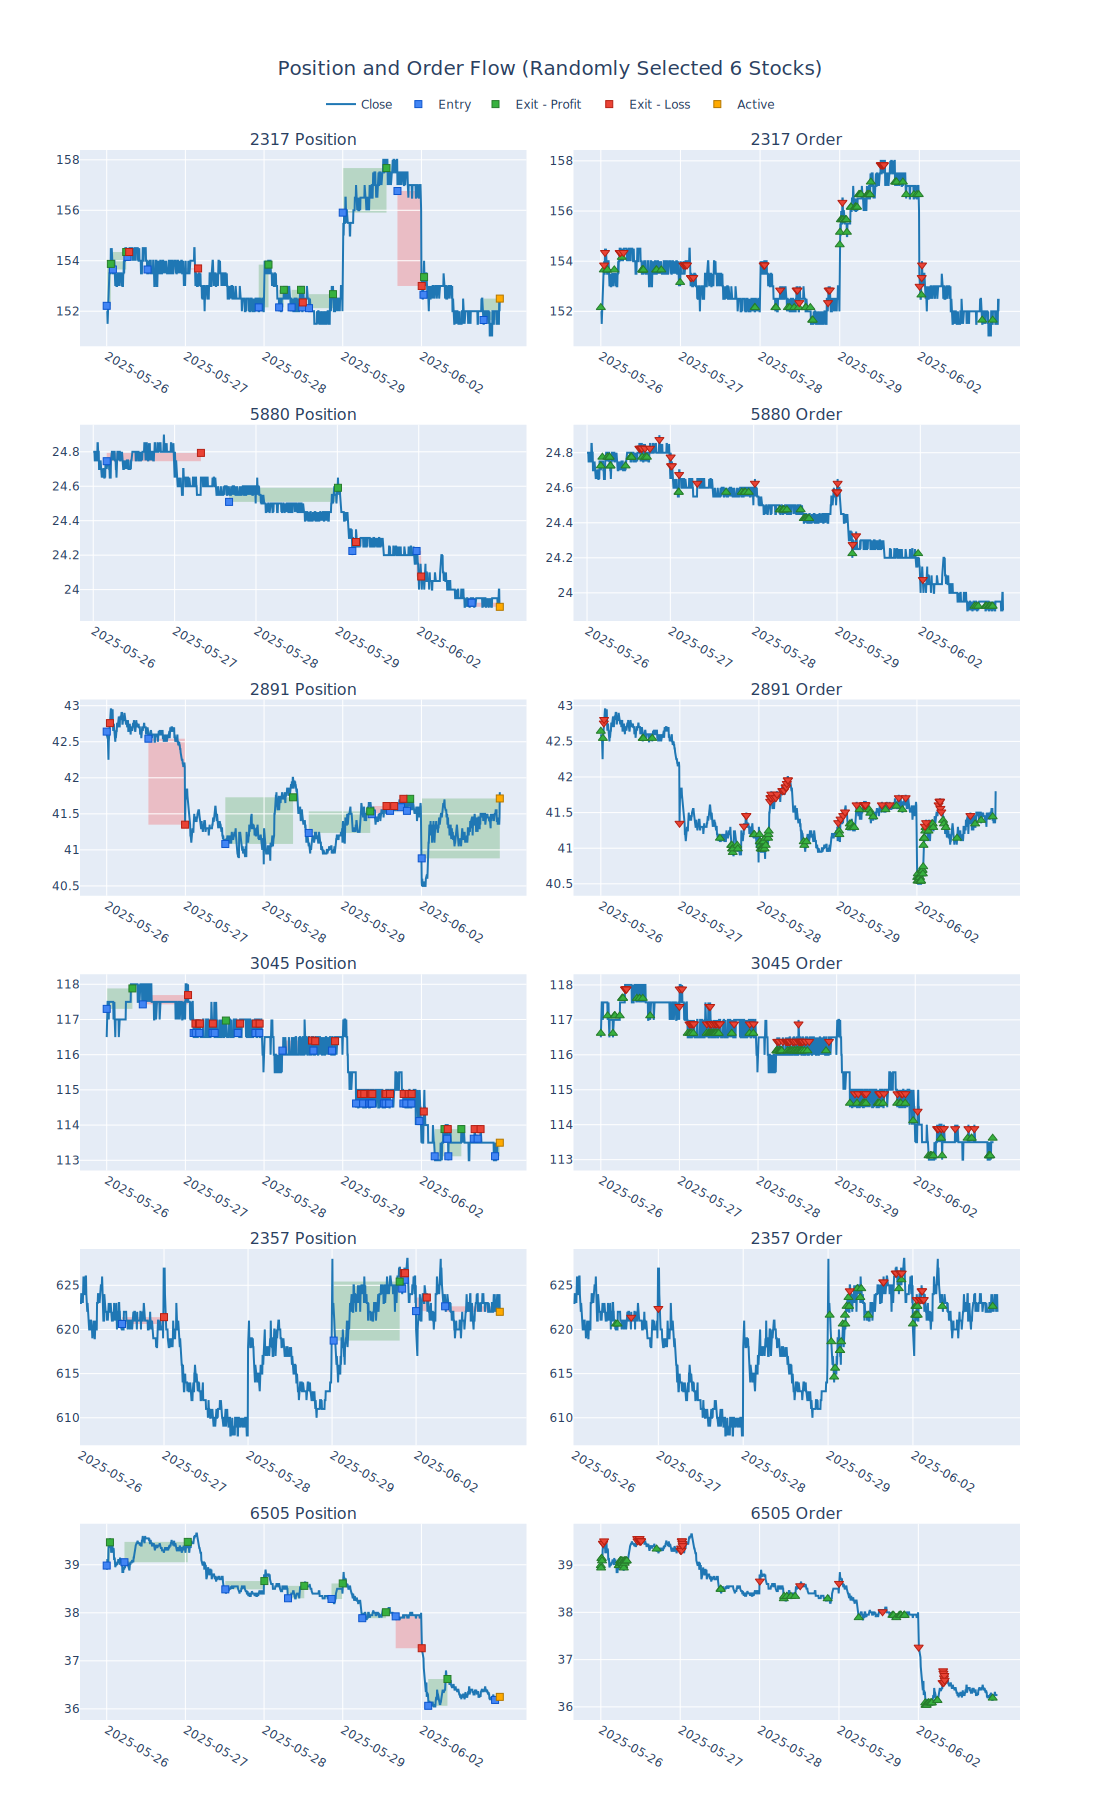

In [234]:
# 個股的部位變化(Position)與訂單進出倉變化(Order)的結果（隨機選取6檔個股）
from plotly.subplots import make_subplots
np.random.seed(320)
n = 6
ticker_chosen = np.random.choice(ticker_order, n, replace=False)
fig = make_subplots(rows=n, cols=2, 
                    horizontal_spacing=0.05,   # 預設 0.2，改小會讓子圖更寬
                    vertical_spacing=0.05,     # 改小會讓子圖更高
                    subplot_titles=sum(
                        [[f'{i} Position', f'{i} Order'] for i in ticker_chosen]
                        , [])  # sum(,[])是把nested list unnest
                    )

# 旗標：只顯示一次圖例
legend_shown = False

for row, ticker in enumerate(ticker_chosen):
    for col, data_type in enumerate(['positions', 'orders']):
        
        if data_type == 'positions':
            subfig = pf_signal.positions.plot(ticker)
        else:
            subfig = pf_signal.orders.plot(ticker)

        subplot_idx = row * 2 + col + 1

        # 設定 subplot 對應的 xref/yref 名稱
        xref = f'x{subplot_idx if subplot_idx > 1 else ""}'
        yref = f'y{subplot_idx if subplot_idx > 1 else ""}'

        for trace in subfig.data:
            # 只保留第一次圖例，其餘關掉
            trace.showlegend = not legend_shown
            fig.add_trace(trace, row=row+1, col=col+1)

        legend_shown = True  # 之後就不再顯示圖例        

        # 加入該子圖的所有 shape（如果有）
        if 'shapes' in subfig.layout:
            for shape in subfig.layout.shapes:
                # shape = shape.copy()  # 避免修改原物件
                shape['xref'] = xref
                shape['yref'] = yref
                fig.add_shape(shape, row=row+1, col=col+1)    
        
        fig_adj_xaxis_subplot(fig, subplot_idx)

# 調整 legend 到圖的上方
fig.update_layout(
    title = dict(
        text=f"Position and Order Flow (Randomly Selected {n} Stocks)",
        x=0.5,  # 水平置中
        xanchor='center',
        font=dict(size=20)
    ),
    margin = dict(t=150),
    height=300*n,
    width=1100,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

show_plotly(fig)    # fig_name='signal_pos_ord_flow'


### from_order_func

#### Strategy Design

- 主要目標：
    - 彌補 from_signals 無法支援加碼／減碼的限制，**明確設計出倉位調整（加碼、減碼）、停利與停損的邏輯**。

- 次要目標：
    - 提升勝率、總報酬率與 Sharpe ratio，同時減少不必要的進出場，以降低手續費成本。

- 資金權重配置：
    
    - 以各股票當下的 **VWAP × Alpha42** 值進行 L1 正規化，作為資金配置比例。

    - 註：Alpha42 是基於 LightGBM 模型預測未來報酬率中，最重要的因子。

- 倉位調整邏輯：

    - 進場訊號（無持倉時）：
        - **fwd_ret_10_pred > 0.1%**
        - **fwd_ret_5_pred > 0.2%** 
        - 任一滿足 → 建倉 80%；兩者皆滿足 → 建倉 120%（允許超過 100% 以充分利用資金）

    - 加碼訊號：
        - 訊號1：
            - **fwd_ret_10_pred > 0.05%** 
            - **過去30分鐘報酬率 > -1%**
            - 全部滿足 → 增倉 20%

        - 訊號2：
            - **fwd_ret_10_pred > 0.08%** 
            - **fwd_ret_5_pred > 0.2%** 
            - 任一滿足 → 增倉 20%；兩者皆滿足 → 增倉 50%

    - 停損訊號：
        - **當前持倉淨損益（扣成本後報酬） < -2%**
        - **過去5分鐘報酬 < -1.5%**
        - **過去10分鐘報酬 < -2%**
        - **過去30分鐘報酬 < -4%**
        - **NATR（正則化平均真實波動）> 0.25**
        - **當前收盤價 / EMA10（10分鐘指數平滑移動平均）∈ (0.98, 1.01)**
        - 滿足 3-4 項 → 減倉 40%； 5-6 項 → 減倉 60%

    - 停利訊號：
        - **當前持倉淨損益 > 0.5%**  →  減倉30%
        - **當前持倉淨損益 > 1.5%**  →  減倉80%

    - 全部出場訊號：
        - **過去5分鐘報酬 < -0.15%**
        - **過去10分鐘報酬 < -0.2%**
        - **當前持倉已回本**
        - **距離首次建倉（當前持倉最早入場）時間超過60分鐘**
        - 距離首次建倉已超過30分鐘時，且滿足任3項以上 → 全部平倉

- 資金與交易限制： 

    - 全部股票共用資金池，並**允許部分下單**，提高資金使用效率。

    - 僅允許**整數股數**下單，單筆下單最少 1 股，最多 2,000 股

    - 初始資金： 1,000,000 元

    - 手續費：每筆交易 **0.1425%**

    - 滑價：每筆交易另計 **0.1%** 滑價

#### Setting

In [235]:
# plt.figure(figsize=(18,6))
# i=20
# p1=stocks1_test.xs(stocks1_test['open'].unstack().columns[i], level='ticker').reset_index(drop=True)[['close']].plot(kind="line", ax=plt.gca())
# p2=stocks1_test['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=10), axis=0).iloc[:,i].reset_index(drop=True).plot(ax=plt.gca())
# p3=stocks1_test['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=30), axis=0).iloc[:,i].reset_index(drop=True).plot(ax=plt.gca())
# p4=(vbt.RSI.run(stocks1_test['close'].unstack().reset_index(drop=True), window=30).rsi.iloc[:,0]).plot(secondary_y=True, ax=plt.gca())
# p5=(vbt.MA.run(close, window=10).ma.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p6=(vbt.MA.run(close, window=60).ma.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p7=(vbt.BBANDS.run(stocks1_test['close'].unstack().reset_index(drop=True), window=15).lower.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p8=(vbt.BBANDS.run(stocks1_test['close'].unstack().reset_index(drop=True), window=60).upper.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p9=stocks1_test['NATR'].unstack().reset_index(drop=True).iloc[:,i].plot(secondary_y=True, ax=plt.gca())
# plt.show()

In [236]:
import numba
from numba import njit
from vectorbt.portfolio import nb as portfolio_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [237]:
@njit
def order_func_nb(c, # context，可用屬性要看github enums.OrderContext https://github.com/polakowo/vectorbt/blob/master/vectorbt/portfolio/enums.py
                  pred1_, pred3_, pred5_, pred10_, pastret5_, pastret10_, pastret30_, weight_, natr_, cummax_close, ema10_,
                  SIZE_TYPE, DIRECTION, FEES, FIXED_FEES, SLIPPAGE, 
                  MIN_SIZE, MAX_SIZE, MAX_ENTRY_AMOUNT_RATIO, MAX_EXIT_AMOUNT_RATIO):

    # price = close_[c.i, c.col]
    price = c.close[c.i, c.col]
    # cummax_price = cummax_close[c.i, c.col]
    pastret5 = pastret5_[c.i, c.col]
    pastret10 = pastret10_[c.i, c.col]
    pastret30 = pastret30_[c.i, c.col]
    pred5 = pred5_[c.i, c.col]
    pred10 = pred10_[c.i, c.col]
    w = weight_[c.i, c.col]
    natr = natr_[c.i, c.col]
    ema10 = ema10_[c.i, c.col]

    # c.value_now: 目前價值
    # c.cash_now: 目前現金
    # c.position_now: 目前持有部位
    # c.return_now: 目前整個組合的收益
    # c.pos_record_now 前一筆完整進出場紀錄 
    # (0: position_id, 1: col, 2: size, 3: entry_time_idx, 4: entry_price, 5: entry_fees, 
    # 6: exit_time_idx, 7: exit_price, 8:exit_fees, 9: pnl, 10: return, 11: direction, 12: status, 13: position id 該檔第幾筆訂單)
    # (direction, status): (0,0):持買倉未平，(0,1):持買倉已平，(1,0):持賣倉未平，(1,1):持賣倉已平

    # c.last_oidx[c.col] 前一筆交易id
    # c.last_val_price[c.col] # 上次執行價格（買入賣出價）
    # c.order_records[c.last_oidx[c.col]] 前一筆交易紀錄 
    # (0: 交易id, 1: col, 2: time_idx, 3: size, 4: price(含滑價), 5: 總費用, 6: 買入0還是賣出1)

    curr_pos = c.position_now  # 目前持倉數
    curr_pos_cost = c.last_val_price[c.col] * (1 + FEES + FIXED_FEES)   # 前一次入場的每股成本
    curr_pos_ret = price / curr_pos_cost - 1
    # curr_ret_from_max = price / cummax_price - 1 # 價格自高點回落比例
    last_entry_time = c.pos_record_now[3]  # 前一次進場時間（若Accumulate=F或設定只有當curr_pos == 0才入場，則兩次交易之方向必相反）
    last_exit_time = c.pos_record_now[6]   # 前一次出場時間
    time_from_last_entry = c.i - last_entry_time
    time_from_last_exit = c.i - last_exit_time
    

    size = 0  # 未滿足以下倉位調整的條件即不進行操作

    # ###### 此區以下為仿from_signals的策略邏輯 ######
    # exit_signal = (pred10<-0.002) + (curr_pos_ret < -0.02) + (0.98 < price /ema10 < 1.01)
    # if curr_pos > 0:
    #     if exit_signal >= 2: # 滿足訊號任2個以上
    #         size = -curr_pos
    
    # if (pred10>0.001) or (pred5>0.002):
    #         size = np.round(c.cash_now * w / price)
    # ###### 此區以上為from_signals的策略邏輯 ######     


    # #### 出場邏輯 #### (先出場再入場)
    if curr_pos > 0:

        sl_signal = (curr_pos_ret < -0.02) + (pastret5 < -0.015) + (pastret10 < -0.02) + (pastret30 < -0.04) + (natr > 0.25) + (0.98 < price /ema10 < 1.01)
        tp_signal1 = (curr_pos_ret > (0.005 + FEES + SLIPPAGE))  # 扣除成本超過1%報酬
        tp_signal2 = (curr_pos_ret > (0.015 + FEES + SLIPPAGE))
        exit_signal = ( (pred5 < -0.0015) +(pred10 < -0.002) + 
                       (curr_pos_ret > (FEES + SLIPPAGE)) +  # 已回本
                        (time_from_last_entry > 60) )  # 至少持倉60分鐘
        
        # 停損：滿足停損訊號(sl_signal)任5件以上，平倉60%；3~4件，平倉40%
        if sl_signal >= 5:
            size = -np.round(curr_pos * 0.6)

        elif sl_signal >= 3: 
            size = -np.round(curr_pos * 0.4)

        # 停利：扣除成本超過1.5%報酬(tp_signal2)，平倉80%，超過1%報酬(tp_signal1)，平倉30%  
        elif tp_signal2:
            size = -np.round(curr_pos * 0.8)

        elif tp_signal1:  
            size = -np.round(curr_pos * 0.3)    
        
        # 全部出倉：至少持倉30分鐘且滿足出倉訊號(exit_signal)任3件以上，全部平倉
        elif (time_from_last_entry > 30) and exit_signal >= 3:  
            size = -curr_pos
        
    # 自訂出場交易股數上限（上限：當前資金*自訂資金上限ratio/收盤價）
    size = max(size, -(c.value_now * MAX_EXIT_AMOUNT_RATIO / price) )  

    # #### 進場邏輯 ####

    add_pos = np.round(c.cash_now * w / price)   # 進場倉位（股數，取整）：每次進場前都更新現有資金(c.cash_now)及權重、收盤價
    entry_signal = (pred10 > 0.001) + (pred5 > 0.002)  # 進場條件
    bonus_signal1 = (pred10 > 0.0005) + (pastret30 >= -0.01) 
    bonus_signal2 = (pred10 > 0.0008) + (pred5 > 0.0012)

    # 進場（此時間點之前未有倉位）：滿足所有進場訊號(entry signal)，入倉120%（為使資金充分利用因此超過100%），只滿足其中1件，入倉80%
    if curr_pos == 0:
        if entry_signal == 2:  
            size = np.round(add_pos * 1.2)  

        elif entry_signal==1:
            size = np.round(add_pos * 0.8)

    # 加碼條件1: 滿足加碼訊號1(bonus_signal1)全部符合，增倉20%
    elif bonus_signal1 == 2:   
        size = np.round(add_pos * 0.2)

    # 加碼條件2: 滿足加碼訊號2(bonus_signal2)全部符合，增倉50%，只滿足1件，增倉20%
    elif bonus_signal2 == 2:
        size = np.round(add_pos * 0.5)
    
    elif bonus_signal2 == 1:
        size = np.round(add_pos * 0.2)

    # 自訂進場交易股數上限（上限：當前資金*自訂資金上限ratio/收盤價）
    size = min(size, (c.value_now * MAX_ENTRY_AMOUNT_RATIO / price))  

    
    return portfolio_nb.order_nb(
        size=size,
        price=price,
        size_type=SIZE_TYPE, # Amount:固定股數；Value：投入金額；Percent：投入金額的比例（隨總額變化）；TargetPercent：讓標的的金額比例在隨著時間變化時平衡回目標比例
        direction=DIRECTION, 
        fees=FEES,
        fixed_fees=FIXED_FEES,
        slippage=SLIPPAGE,
        min_size=MIN_SIZE,
        size_granularity=1,  # 單位為1股
        max_size=MAX_SIZE,   # 限制每個時間點每支個股的交易股數上限（進出場皆限制）
        reject_prob=0.0,
        allow_partial=True,  # 是否允許部分資金投入（當資金不足時）
        raise_reject=False,  # 異常時是否需要中止
        log=True
    )


In [238]:
df = stocks1_test.copy()

# open = df['open'].unstack().values
close = df['close'].unstack().values
cummax_close = df['close'].unstack().cummax().values
# vwap = df['vwap'].unstack().values
# volume = df['volume'].unstack().values
pastret5 = df['past_ret_5'].unstack().values
pastret10 = df['past_ret_10'].unstack().values
pastret30 = df['close'].unstack().transform(lambda x: x.pct_change(periods=30)).values
pred1 = df['fwd_ret_1_pred'].unstack().values
pred3 = df['fwd_ret_3_pred'].unstack().values
pred5 = df['fwd_ret_5_pred'].unstack().values
pred10 = df['fwd_ret_10_pred'].unstack().values
natr = df['NATR'].unstack().values
ema10 = df['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=10), axis=0).values


# 權重設計（如用預測值加權）
# rk_alpha042 = df['alpha042'].groupby('date').rank()
# rk_alpha041 = df['alpha041'].groupby('date').rank()
# minmax_alpha041 = df['alpha041'].unstack().apply(lambda x: (x-min(x))/(max(x)-min(x)), axis=1)
# weight = (( df['alpha042'].unstack() * minmax_alpha041) / df['close'].unstack()).apply(lambda x: x/sum(x), axis=1).values
weight = (df['alpha042'].unstack() * df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).values

# weight = (df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).values


In [239]:
def simu_vbt_from_order_func(SIZE_TYPE=SizeType.Amount, DIRECTION=Direction.LongOnly, INIT_CASH=1_000_000,
                             FEES=0.001425, FIXED_FEES=0, SLIPPAGE=0.001, 
                             MIN_SIZE=1, MAX_SIZE=np.inf, MAX_ENTRY_AMOUNT_RATIO=1, MAX_EXIT_AMOUNT_RATIO=1):
    
    return vbt.Portfolio.from_order_func(
        close,
        order_func_nb,
        pred1, pred3, pred5, pred10, pastret5, pastret10, pastret30, weight, natr, cummax_close, ema10, # *args for order_func_nb
        SIZE_TYPE, DIRECTION, FEES, FIXED_FEES, SLIPPAGE, 
        MIN_SIZE, MAX_SIZE, MAX_ENTRY_AMOUNT_RATIO, MAX_EXIT_AMOUNT_RATIO,
        init_cash=INIT_CASH,
        cash_sharing=True,
        update_value=True,
        group_by=True,  # 每個時間點視為同一組
        freq='1min'
    )

In [240]:
pf_orderfnb = simu_vbt_from_order_func(MAX_SIZE=2000, MAX_ENTRY_AMOUNT_RATIO=0.15, MAX_EXIT_AMOUNT_RATIO=0.15) # 單次進出場資金流動不得超過總資金15%

#### Table Results

In [241]:
pf_orderfnb.stats()

Start                                                 0
End                                                1329
Period                                  0 days 22:10:00
Start Value                                   1000000.0
End Value                                1095692.610705
Total Return [%]                               9.569261
Benchmark Return [%]                           -1.89655
Max Gross Exposure [%]                        99.987445
Total Fees Paid                            38004.735395
Max Drawdown [%]                               1.540256
Max Drawdown Duration                   0 days 02:36:00
Total Trades                                        278
Total Closed Trades                                 256
Total Open Trades                                    22
Open Trade PnL                              2127.118025
Win Rate [%]                                  63.671875
Best Trade [%]                                 2.788311
Worst Trade [%]                               -4

In [242]:
print(f"Alpha: {pf_orderfnb.alpha():.3e}, \nBeta: {pf_orderfnb.beta():.3}")

Alpha: 3.911e+19, 
Beta: 1.17


In [243]:
pf_orderfnb_orders = pf_orderfnb.orders.records_readable
# 將時間與股票的encoding轉成真實值
pf_orderfnb_orders['Timestamp'] = datetime_order[pf_orderfnb_orders['Timestamp']]
pf_orderfnb_orders['Column'] = ticker_order[pf_orderfnb_orders['Column']]

In [244]:
# 各檔個股下單次數
pf_orderfnb_orders.query('Side=="Buy"').groupby('Column').size()

Column
1216    178
2207    225
2303    161
2308    177
2317    265
2330     83
2345    156
2357    215
2382    201
2412    317
2454    297
2603    183
2880    174
2881    153
2882    267
2884    225
2885    225
2886    325
2891    249
2892    352
3045    331
3711    241
5880    190
6505    155
6669    223
dtype: int64

In [245]:
# 各檔個股出場次數
pf_orderfnb_orders.query('Side=="Sell"').groupby('Column').size()

Column
1216     5
2207     9
2303     7
2308     8
2317     9
2330     8
2345     8
2357    10
2382     8
2412    11
2454    27
2603     8
2880     3
2881     6
2882    10
2884     3
2885     5
2886     6
2891    11
2892     9
3045    25
3711    12
5880     7
6505    21
6669    20
dtype: int64

In [246]:
# 請求的訂單數據（不一定成交）
pf_orderfnb_orders.sort_values(by=['Timestamp'], ascending=True)

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,2207,2025-05-26 09:00:00,241.0,621.62100,213.480192,Buy
13,13,6669,2025-05-26 09:00:00,65.0,2307.30500,213.714126,Buy
12,12,6505,2025-05-26 09:00:00,104.0,38.98895,5.778162,Buy
11,11,3711,2025-05-26 09:00:00,35.0,142.14200,7.089332,Buy
10,10,3045,2025-05-26 09:00:00,221.0,116.61650,36.725451,Buy
...,...,...,...,...,...,...,...
5819,5819,2454,2025-06-02 13:22:00,1.0,1236.23500,1.761635,Buy
5820,5820,2454,2025-06-02 13:23:00,1.0,1236.23500,1.761635,Buy
5822,5822,2454,2025-06-02 13:30:00,41.0,1258.74000,73.541885,Sell
5821,5821,2303,2025-06-02 13:30:00,2.0,46.90305,0.133674,Sell


In [247]:
# 實際成交的訂單數據（entry time跟exit time分別代表該訂單最早開始入倉的時間以及最晚清空倉位的時間）

# pf_orderfnb.asset_flow()
pf_orderfnb_trades = pf_orderfnb.trades.records_readable
# entry 和 exit 時間轉成真正的 datetime
pf_orderfnb_trades['Entry Timestamp'] = datetime_order[pf_orderfnb_trades['Entry Timestamp']]
pf_orderfnb_trades['Exit Timestamp'] = datetime_order[pf_orderfnb_trades['Exit Timestamp']]

# 轉回真正的股票代號
pf_orderfnb_trades['Column'] = ticker_order[pf_orderfnb_trades['Column']]

pf_orderfnb_trades.sort_values(by=['Column', 'Entry Timestamp'], ascending=True) #.sort_values(by='PnL', ascending=False)


,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,1216,1883.0,2025-05-26 10:30:00,79.845789,214.248210,2025-05-27 10:26:00,81.5184,218.736285,2716.541909,0.018068,Long,Closed,0
1,1,1216,1069.0,2025-05-26 10:30:00,79.845789,121.631087,2025-05-27 10:27:00,81.5184,124.179017,1542.210993,0.018068,Long,Closed,0
2,2,1216,1937.0,2025-05-27 11:26:00,80.713567,222.787605,2025-05-28 11:13:00,81.2187,224.181886,531.473559,0.003399,Long,Closed,1
3,3,1216,149.0,2025-05-27 11:26:00,80.713567,17.137508,2025-05-28 11:14:00,81.2187,17.244760,40.882581,0.003399,Long,Closed,1
4,4,1216,2.0,2025-05-28 11:58:00,81.081000,0.231081,2025-05-29 09:03:00,81.5184,0.232327,0.411392,0.002537,Long,Closed,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,273,6669,66.0,2025-05-29 12:00:00,2396.695148,225.409179,2025-06-02 09:07:00,2417.5800,227.373399,925.617634,0.005852,Long,Closed,203
274,274,6669,66.0,2025-05-29 12:00:00,2396.695148,225.409179,2025-06-02 09:08:00,2427.5700,228.312959,1584.018075,0.010014,Long,Closed,203
275,275,6669,66.0,2025-05-29 12:00:00,2396.695148,225.409179,2025-06-02 09:09:00,2422.5750,227.843179,1254.817854,0.007933,Long,Closed,203
276,276,6669,38.0,2025-05-29 12:00:00,2396.695148,129.781042,2025-06-02 09:10:00,2412.5850,130.641478,343.391844,0.003770,Long,Closed,203


#### Figure Results

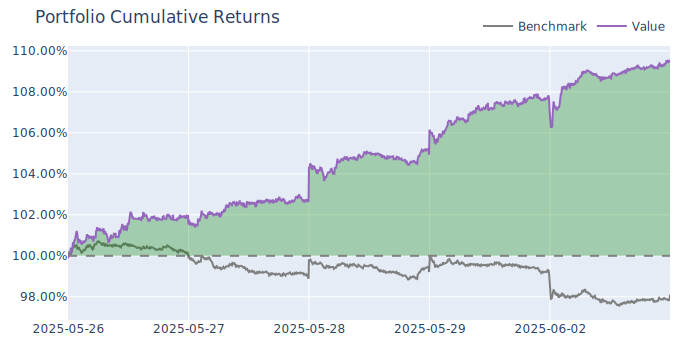

In [248]:
fig = pf_orderfnb.plot_cum_returns(title='Portfolio Cumulative Returns')
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='orderfnb_cum_ret'

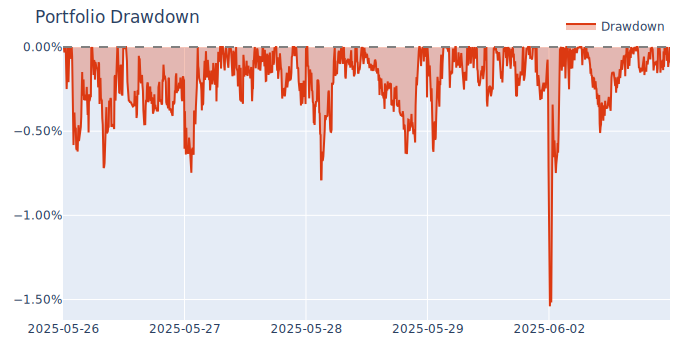

In [249]:
# 回撤深度（相對歷史高點跌幅）
fig = pf_orderfnb.plot_underwater(title='Portfolio Drawdown')
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='orderfnb_drawdown'

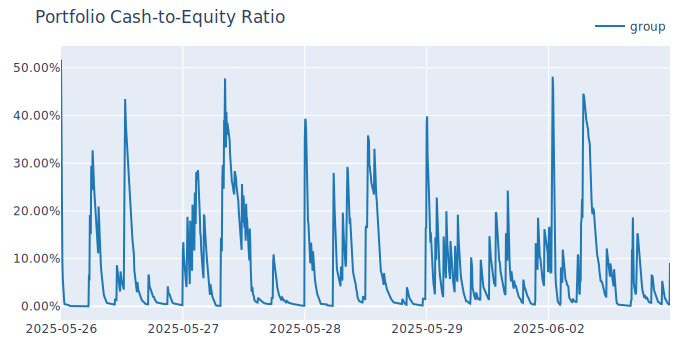

In [250]:
fig = (pf_orderfnb.cash()/pf_orderfnb.value()).vbt.plot(title='Portfolio Cash-to-Equity Ratio')
fig.update_layout(yaxis_tickformat='.2%')
show_plotly(fig_adj_xaxis(fig))     # fig_name='orderfnb_cash2equity'

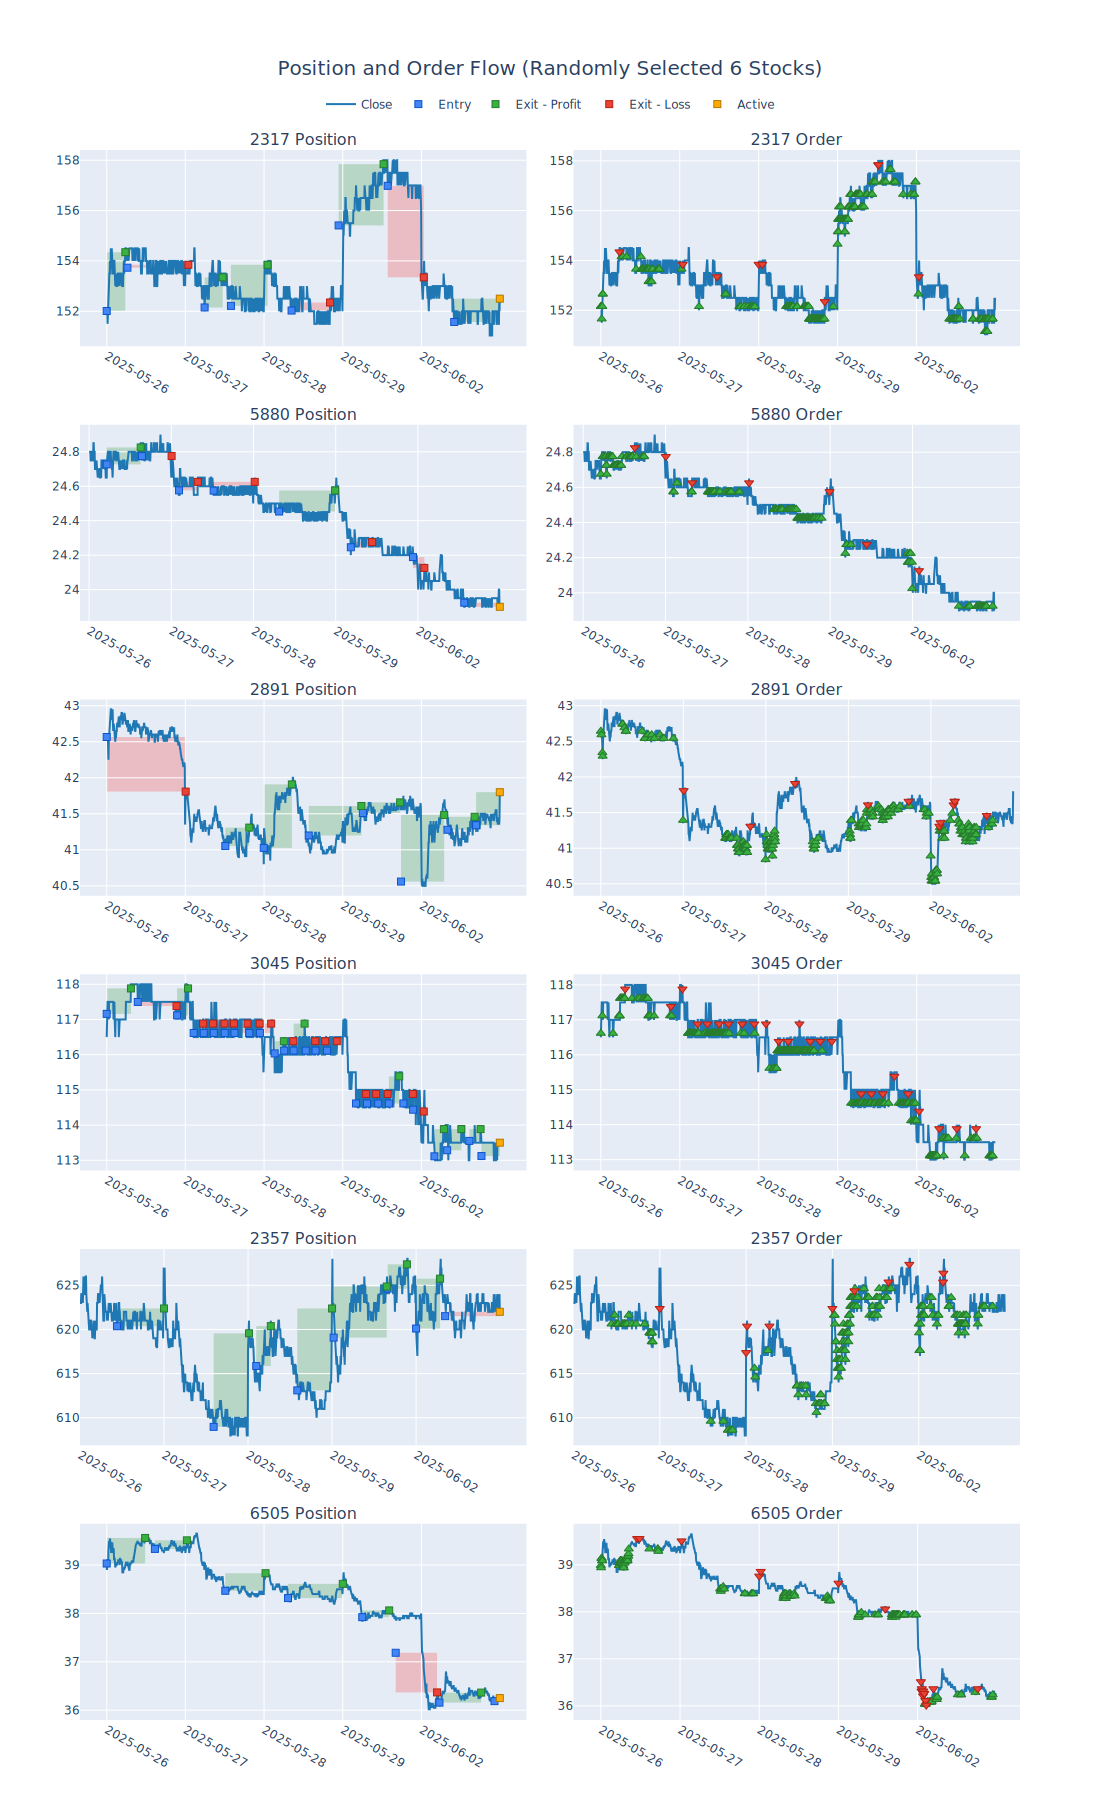

In [251]:
# 個股的部位變化(Position)與訂單進出倉變化(Order)的結果（隨機選取6檔個股）

np.random.seed(320)
n = 6
ticker_chosen = np.random.choice(len(ticker_order), n, replace=False)
fig = make_subplots(rows=n, cols=2, 
                    horizontal_spacing=0.05,   # 預設 0.2，改小會讓子圖更寬
                    vertical_spacing=0.05,     # 改小會讓子圖更高
                    subplot_titles=sum(
                        [[f'{ticker_order[i]} Position', f'{ticker_order[i]} Order'] for i in ticker_chosen]
                        , [])  # sum(,[])是把nested list unnest
                    )

# 旗標：只顯示一次圖例
legend_shown = False

for row, ticker in enumerate(ticker_chosen):
    for col, data_type in enumerate(['positions', 'orders']):
        
        if data_type == 'positions':
            subfig = pf_orderfnb.positions.plot(ticker)
        else:
            subfig = pf_orderfnb.orders.plot(ticker)

        subplot_idx = row * 2 + col + 1

        # 設定 subplot 對應的 xref/yref 名稱
        xref = f'x{subplot_idx if subplot_idx > 1 else ""}'
        yref = f'y{subplot_idx if subplot_idx > 1 else ""}'

        for trace in subfig.data:
            # 只保留第一次圖例，其餘關掉
            trace.showlegend = not legend_shown
            fig.add_trace(trace, row=row+1, col=col+1)

        legend_shown = True  # 之後就不再顯示圖例        

        # 加入該子圖的所有 shape（如果有）
        if 'shapes' in subfig.layout:
            for shape in subfig.layout.shapes:
                # shape = shape.copy()  # 避免修改原物件
                shape['xref'] = xref
                shape['yref'] = yref
                fig.add_shape(shape, row=row+1, col=col+1)    
        
        fig_adj_xaxis_subplot(fig, subplot_idx)

# 調整 legend 到圖的上方
fig.update_layout(
        title = dict(
        text=f"Position and Order Flow (Randomly Selected {n} Stocks)",
        x=0.5,  # 水平置中
        xanchor='center',
        font=dict(size=20)
    ),
    margin = dict(t=150),
    height=300*n,
    width=1100,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
  
show_plotly(fig)     # fig_name='orderfnb_pos_ord_flow'

# i=23
# pf2.positions.plot(i, title = ticker_order[i]).show()
# pf2.orders.plot(i, title=ticker_order[i]).show()